In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
df = pd.read_csv('../data/day_approach_maskedID_timeseries.csv')
df.head()

nr. sessions  total km  km Z3-4  km Z5-T1-T2  km sprinting  \
0           1.0       5.8      0.0          0.6           1.2   
1           0.0       0.0      0.0          0.0           0.0   
2           1.0       0.0      0.0          0.0           0.0   
3           0.0       0.0      0.0          0.0           0.0   
4           1.0       0.0      0.0          0.0           0.0   

   strength training  hours alternative  perceived exertion  \
0                0.0               0.00                0.11   
1                0.0               0.00               -0.01   
2                1.0               0.00                0.10   
3                0.0               0.00               -0.01   
4                0.0               1.08                0.08   

   perceived trainingSuccess  perceived recovery  ...  km Z5-T1-T2.6  \
0                       0.00                0.18  ...            0.0   
1                      -0.01               -0.01  ...            0.5   
2                       0.00                0.17  ...            0.0   
3                      -0.01               -0.01  ...            0.0   
4                       0.00                0.18  ...            0.0   

   km sprinting.6  strength training.6  hours alternative.6  \
0             0.0                  0.0                  1.0   
1             1.2                  0.0                  0.0   
2             0.0                  0.0                  0.0   
3             0.0                  1.0                  0.0   
4             0.0                  0.0                  0.0   

   perceived exertion.6  perceived trainingSuccess.6  perceived recovery.6  \
0                  0.10                         0.00                  0.15   
1                  0.10                         0.00                  0.17   
2                 -0.01                        -0.01                 -0.01   
3                  0.10                         0.00                  0.17   
4                  0.11                         0.00                  0.17   

   Athlete ID  injury  Date  
0           0       0     0  
1           0       0     1  
2           0       0     2  
3           0       0     3  
4           0       0     4  

[5 rows x 73 columns]

## Choosing an athlete to predict: ##

I choose the athlete that has the higher percentage of injury

In [4]:
# how likely does each athlete get injured?
perc_injured_per_athlete = df.groupby(['Athlete ID']).agg({'injury':'sum','Date':'count'}).reset_index()
perc_injured_per_athlete['perc_injury'] = perc_injured_per_athlete['injury'] / df.groupby(['Athlete ID']).agg({'injury':'count'})['injury']
perc_injured_per_athlete = perc_injured_per_athlete.sort_values(by = ['perc_injury'])
perc_injured_per_athlete

Athlete ID  injury  Date  perc_injury
73          73       0   192     0.000000
62          62       0   196     0.000000
46          46       0   272     0.000000
72          72       0   216     0.000000
31          31       0   231     0.000000
..         ...     ...   ...          ...
68          68       8   235     0.034043
36          36      22   638     0.034483
26          26      35   884     0.039593
42          42      32   744     0.043011
29          29      33   730     0.045205

[74 rows x 4 columns]

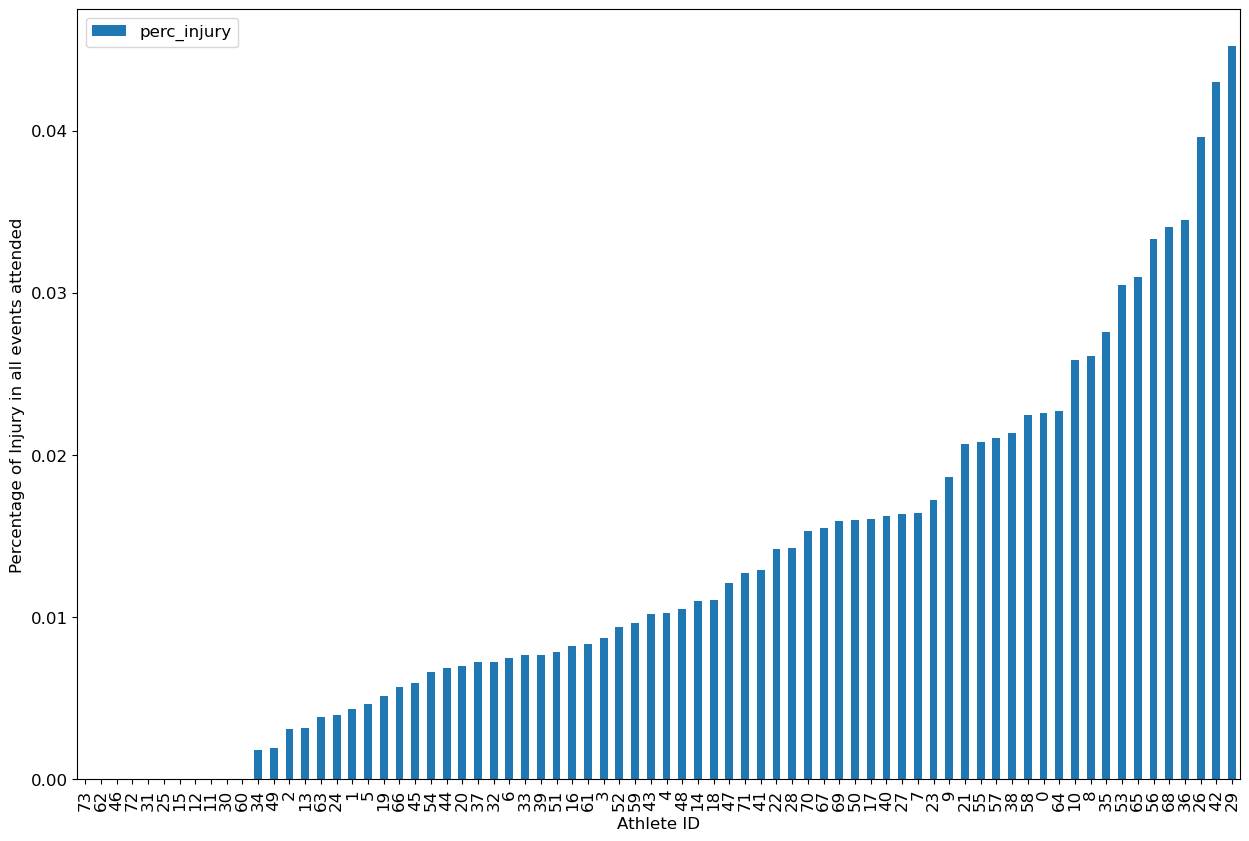

In [5]:
perc_injured_per_athlete.plot.bar('Athlete ID','perc_injury', figsize = (15,10))
plt.xlabel('Athlete ID')
plt.ylabel('Percentage of Injury in all events attended')
plt.savefig('../figures/athlete_injury.png')
plt.show()

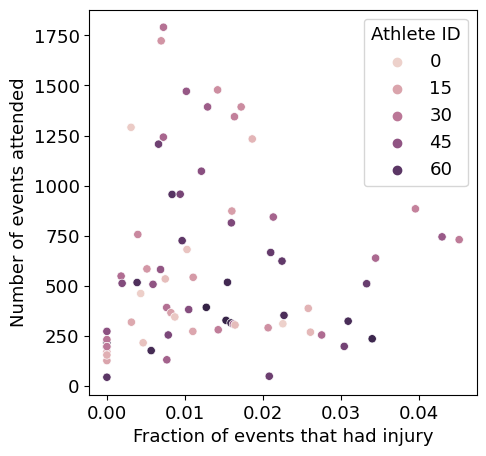

In [101]:
# find which athletes competed in a lot of games AND get injured more frequently
plt.figure(figsize=(5,5))
sns.scatterplot(data=perc_injured_per_athlete, x='perc_injury', y='Date', hue='Athlete ID')
plt.xlabel('Fraction of events that had injury')
plt.ylabel('Number of events attended')
plt.savefig('../figures/athlete scatter.png',bbox_inches='tight')

plt.show()

## Exploratory Data Analysis:

In [515]:
df_29 = df[df['Athlete ID'] == 29]
df_29.head()

nr. sessions  total km  km Z3-4  km Z5-T1-T2  km sprinting  \
17545           1.0       9.1      0.0          0.0           0.0   
17546           1.0       8.6      2.0          2.0           0.0   
17547           1.0       8.4      0.0          0.0           0.0   
17548           1.0       9.7      1.2          1.0           0.0   
17549           0.0       0.0      0.0          0.0           0.0   

       strength training  hours alternative  perceived exertion  \
17545                0.0                0.0                0.09   
17546                0.0                0.0                0.11   
17547                0.0                0.0                0.09   
17548                0.0                0.0                0.12   
17549                0.0                0.0               -0.01   

       perceived trainingSuccess  perceived recovery  ...  km Z5-T1-T2.6  \
17545                       0.00                0.18  ...            0.0   
17546                       0.00                0.18  ...            1.0   
17547                       0.00                0.17  ...            0.0   
17548                       0.00                0.19  ...            1.4   
17549                      -0.01               -0.01  ...            0.0   

       km sprinting.6  strength training.6  hours alternative.6  \
17545             0.0                  0.0                  0.0   
17546             0.2                  0.0                  0.0   
17547             0.0                  0.0                  0.0   
17548             0.0                  0.0                  0.0   
17549             0.0                  0.0                  0.0   

       perceived exertion.6  perceived trainingSuccess.6  \
17545                  0.09                         0.00   
17546                  0.10                         0.00   
17547                  0.09                         0.00   
17548                  0.12                         0.00   
17549                 -0.01                        -0.01   

       perceived recovery.6  Athlete ID  injury  Date  
17545                  0.16          29       0     0  
17546                  0.19          29       0     1  
17547                  0.18          29       0     2  
17548                  0.18          29       0     3  
17549                 -0.01          29       0     4  

[5 rows x 73 columns]

In [9]:
df_29.shape

(730, 73)

In [10]:
df_29.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 17545 to 42445
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nr. sessions                 730 non-null    float64
 1   total km                     730 non-null    float64
 2   km Z3-4                      730 non-null    float64
 3   km Z5-T1-T2                  730 non-null    float64
 4   km sprinting                 730 non-null    float64
 5   strength training            730 non-null    float64
 6   hours alternative            730 non-null    float64
 7   perceived exertion           730 non-null    float64
 8   perceived trainingSuccess    730 non-null    float64
 9   perceived recovery           730 non-null    float64
 10  nr. sessions.1               730 non-null    float64
 11  total km.1                   730 non-null    float64
 12  km Z3-4.1                    730 non-null    float64
 13  km Z5-T1-T2.1 

In [12]:
df_29['Date'].describe()

count     730.000000
mean     1127.747945
std       900.112011
min         0.000000
25%       182.250000
50%       931.500000
75%      1710.750000
max      2651.000000
Name: Date, dtype: float64

### Explore target variable ###

In [511]:
df_29['injury'].value_counts()

0    696
1     33
Name: injury, dtype: int64

In [14]:
df_29['injury'].value_counts(normalize=True)

0    0.954795
1    0.045205
Name: injury, dtype: float64

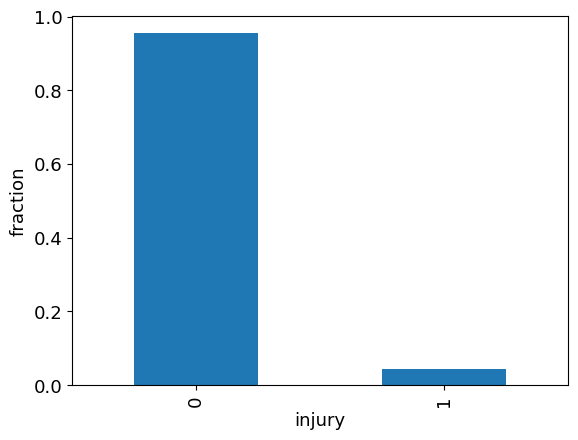

In [97]:
pd.value_counts(df_29['injury'],normalize=True).plot.bar()
plt.xlabel('injury')
plt.ylabel('fraction')
plt.savefig('../figures/injury.png')
plt.show()

### Explore the features ###

In [16]:
other_cols = ['Athlete ID','injury', 'Date']
cont_ftrs = [col for col in df if col not in other_cols]
cat_ftrs = ['Athlete ID']

nr. sessions
count    730.000000
mean       0.879452
std        0.522986
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions, dtype: float64


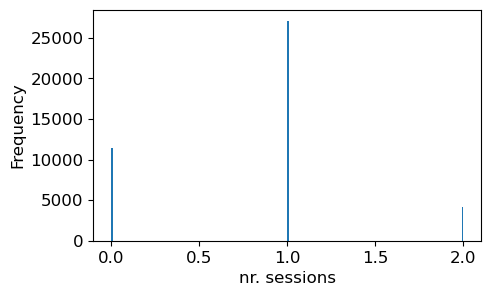

total km
count    730.000000
mean       5.383699
std        4.937621
min        0.000000
25%        0.000000
50%        5.900000
75%        8.800000
max       45.800000
Name: total km, dtype: float64


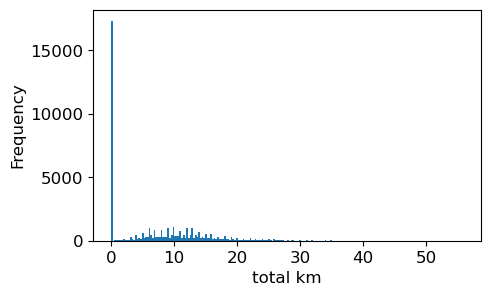

km Z3-4
count    730.000000
mean       0.396712
std        1.284364
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.300000
Name: km Z3-4, dtype: float64


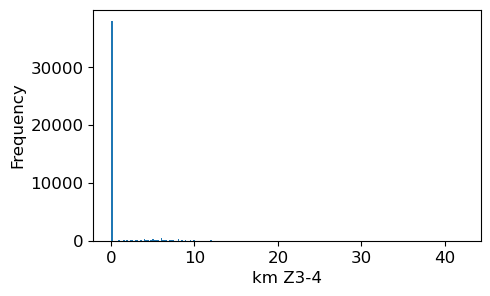

km Z5-T1-T2
count    730.000000
mean       0.336849
std        1.041840
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.100000
Name: km Z5-T1-T2, dtype: float64


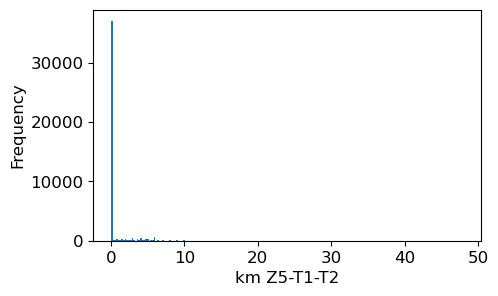

km sprinting
count    730.000000
mean       0.164110
std        0.462325
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: km sprinting, dtype: float64


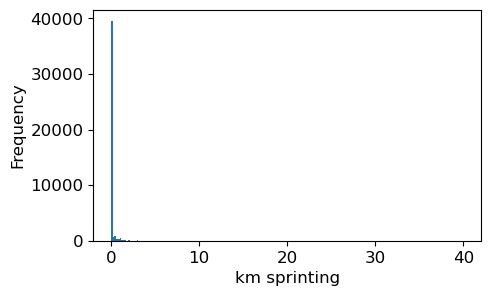

strength training
count    730.000000
mean       0.126027
std        0.359861
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training, dtype: float64


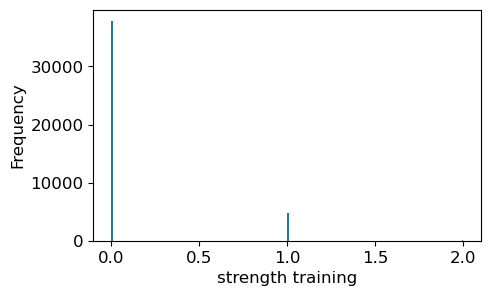

hours alternative
count    730.000000
mean       0.182041
std        0.484472
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: hours alternative, dtype: float64


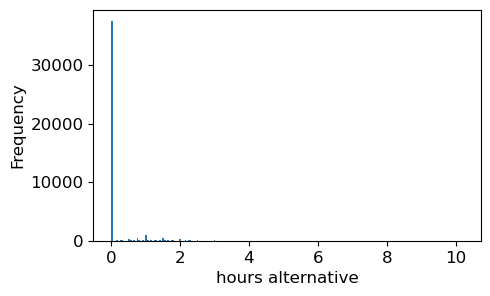

perceived exertion
count    730.000000
mean       0.212753
std        0.231519
min       -0.010000
25%        0.060000
50%        0.110000
75%        0.360000
max        1.000000
Name: perceived exertion, dtype: float64


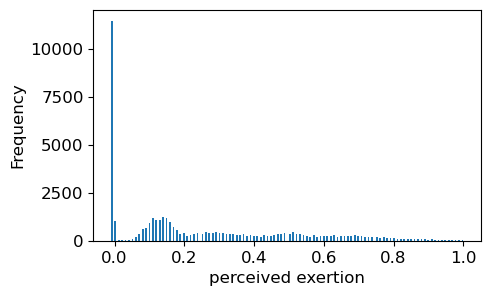

perceived trainingSuccess
count    730.000000
mean       0.398301
std        0.412572
min       -0.010000
25%        0.000000
50%        0.300000
75%        0.840000
max        1.000000
Name: perceived trainingSuccess, dtype: float64


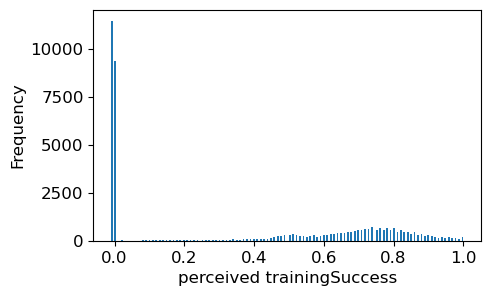

perceived recovery
count    730.000000
mean       0.136356
std        0.105737
min       -0.010000
25%        0.060000
50%        0.160000
75%        0.190000
max        0.570000
Name: perceived recovery, dtype: float64


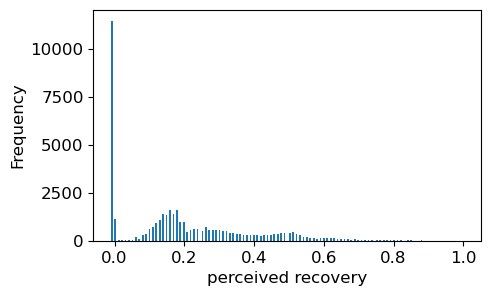

nr. sessions.1
count    730.000000
mean       0.882192
std        0.536550
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.1, dtype: float64


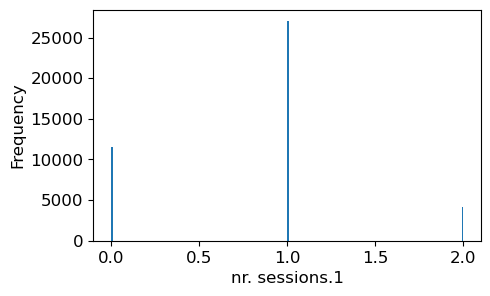

total km.1
count    730.000000
mean       5.355479
std        5.069257
min        0.000000
25%        0.000000
50%        5.800000
75%        8.700000
max       45.800000
Name: total km.1, dtype: float64


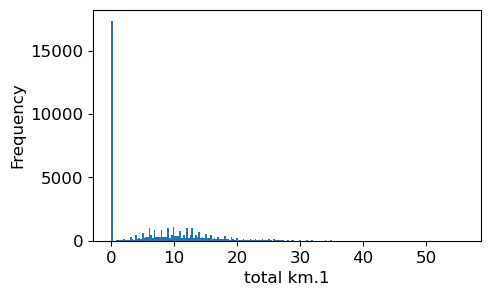

km Z3-4.1
count    730.000000
mean       0.399726
std        1.285393
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.300000
Name: km Z3-4.1, dtype: float64


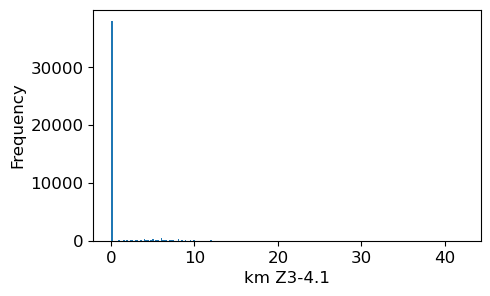

km Z5-T1-T2.1
count    730.000000
mean       0.325068
std        1.041137
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.100000
Name: km Z5-T1-T2.1, dtype: float64


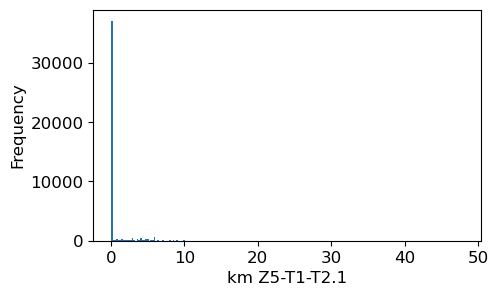

km sprinting.1
count    730.000000
mean       0.151233
std        0.416866
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.400000
Name: km sprinting.1, dtype: float64


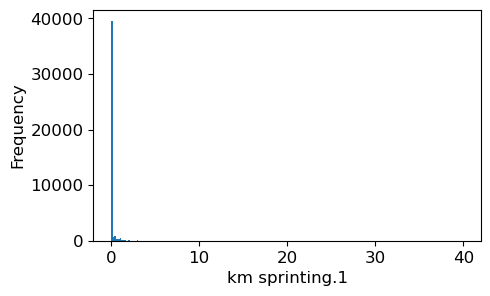

strength training.1
count    730.000000
mean       0.131507
std        0.369212
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.1, dtype: float64


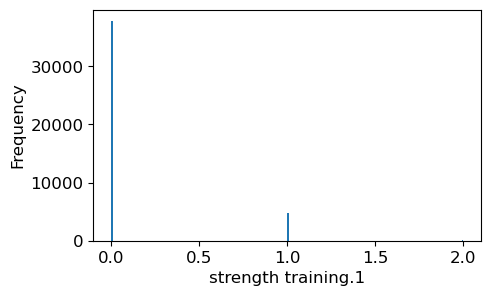

hours alternative.1
count    730.000000
mean       0.200192
std        0.514653
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: hours alternative.1, dtype: float64


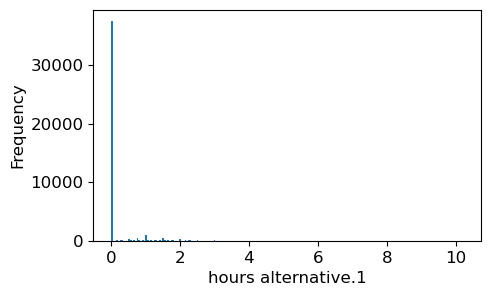

perceived exertion.1
count    730.000000
mean       0.211356
std        0.229627
min       -0.010000
25%        0.060000
50%        0.110000
75%        0.370000
max        1.000000
Name: perceived exertion.1, dtype: float64


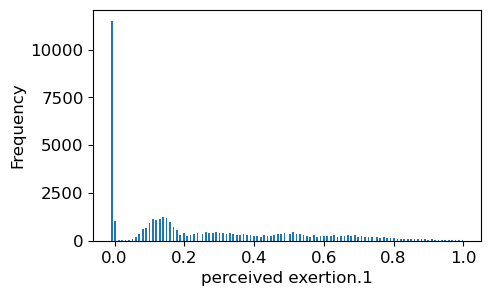

perceived trainingSuccess.1
count    730.000000
mean       0.396562
std        0.411312
min       -0.010000
25%        0.000000
50%        0.300000
75%        0.840000
max        0.980000
Name: perceived trainingSuccess.1, dtype: float64


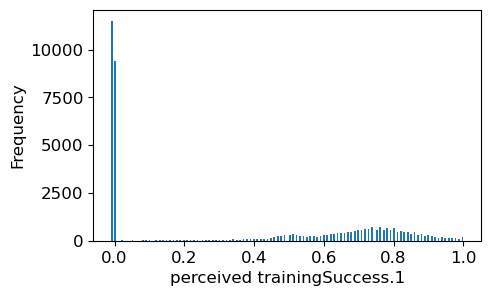

perceived recovery.1
count    730.000000
mean       0.135795
std        0.106570
min       -0.010000
25%        0.050000
50%        0.160000
75%        0.190000
max        0.570000
Name: perceived recovery.1, dtype: float64


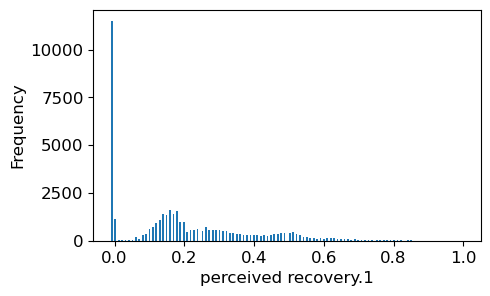

nr. sessions.2
count    730.000000
mean       0.883562
std        0.530423
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.2, dtype: float64


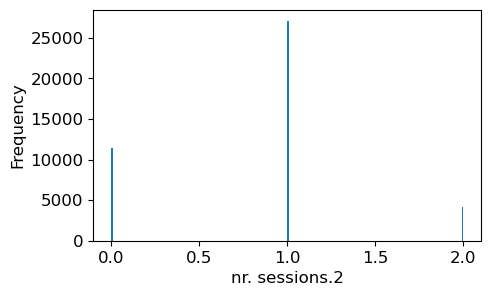

total km.2
count    730.000000
mean       5.388767
std        4.923495
min        0.000000
25%        0.000000
50%        5.900000
75%        8.700000
max       45.800000
Name: total km.2, dtype: float64


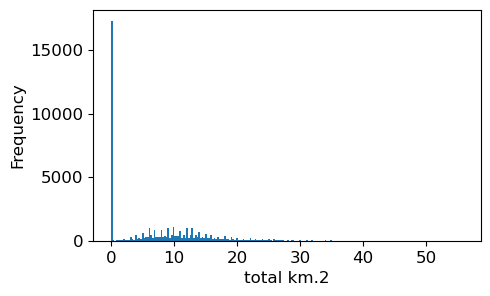

km Z3-4.2
count    730.000000
mean       0.412877
std        1.321542
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        9.000000
Name: km Z3-4.2, dtype: float64


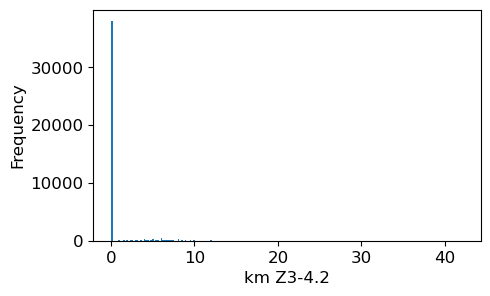

km Z5-T1-T2.2
count    730.000000
mean       0.359589
std        1.113120
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: km Z5-T1-T2.2, dtype: float64


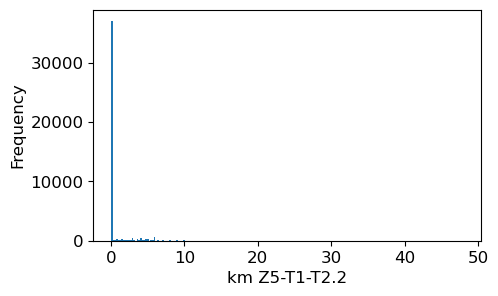

km sprinting.2
count    730.000000
mean       0.150411
std        0.407719
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.400000
Name: km sprinting.2, dtype: float64


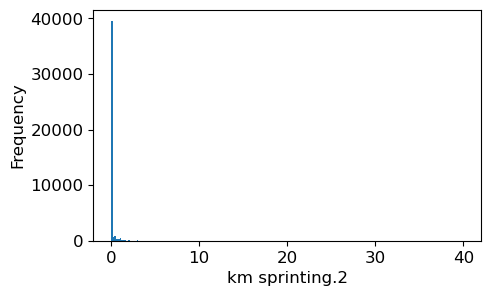

strength training.2
count    730.000000
mean       0.126027
std        0.363653
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.2, dtype: float64


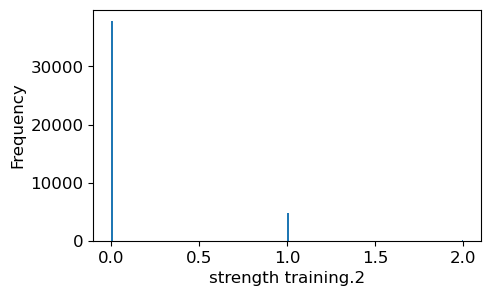

hours alternative.2
count    730.000000
mean       0.188205
std        0.492770
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: hours alternative.2, dtype: float64


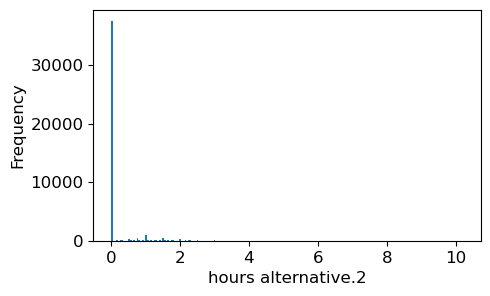

perceived exertion.2
count    730.000000
mean       0.211658
std        0.229077
min       -0.010000
25%        0.060000
50%        0.110000
75%        0.370000
max        1.000000
Name: perceived exertion.2, dtype: float64


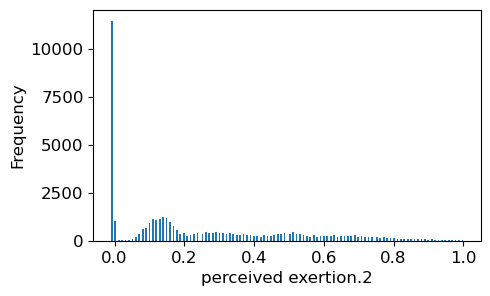

perceived trainingSuccess.2
count    730.000000
mean       0.398795
std        0.412014
min       -0.010000
25%        0.000000
50%        0.325000
75%        0.840000
max        0.990000
Name: perceived trainingSuccess.2, dtype: float64


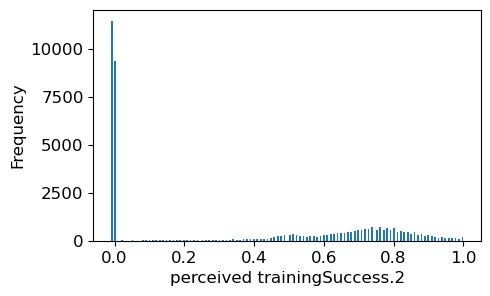

perceived recovery.2
count    730.000000
mean       0.135589
std        0.104746
min       -0.010000
25%        0.060000
50%        0.160000
75%        0.190000
max        0.570000
Name: perceived recovery.2, dtype: float64


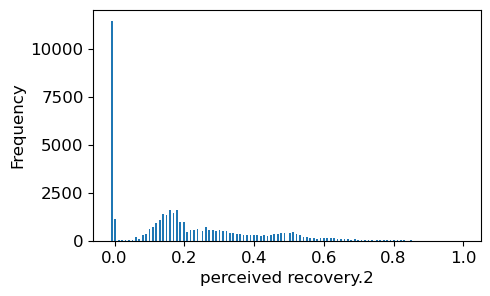

nr. sessions.3
count    730.000000
mean       0.880822
std        0.532396
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.3, dtype: float64


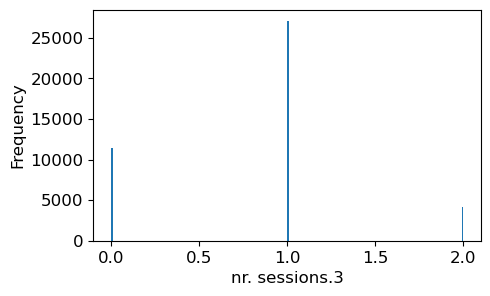

total km.3
count    730.000000
mean       5.471507
std        5.297693
min        0.000000
25%        0.000000
50%        5.900000
75%        8.775000
max       57.000000
Name: total km.3, dtype: float64


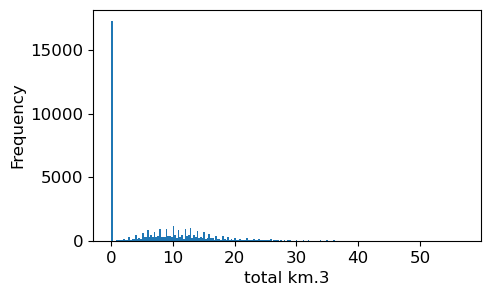

km Z3-4.3
count    730.000000
mean       0.412055
std        1.330333
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.000000
Name: km Z3-4.3, dtype: float64


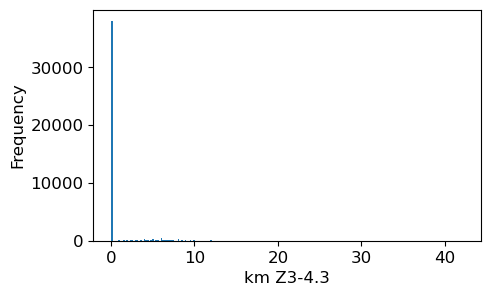

km Z5-T1-T2.3
count    730.000000
mean       0.353288
std        1.105800
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.600000
Name: km Z5-T1-T2.3, dtype: float64


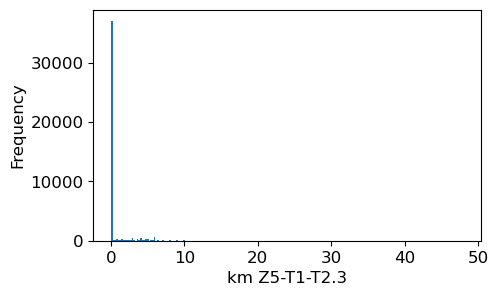

km sprinting.3
count    730.000000
mean       0.161370
std        0.470663
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: km sprinting.3, dtype: float64


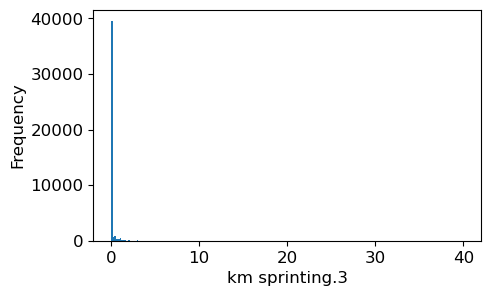

strength training.3
count    730.000000
mean       0.126027
std        0.359861
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.3, dtype: float64


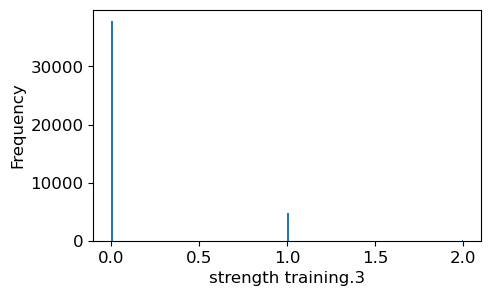

hours alternative.3
count    730.000000
mean       0.192767
std        0.504683
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: hours alternative.3, dtype: float64


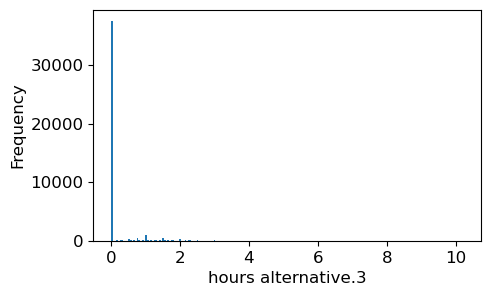

perceived exertion.3
count    730.000000
mean       0.215589
std        0.234720
min       -0.010000
25%        0.052500
50%        0.110000
75%        0.370000
max        1.000000
Name: perceived exertion.3, dtype: float64


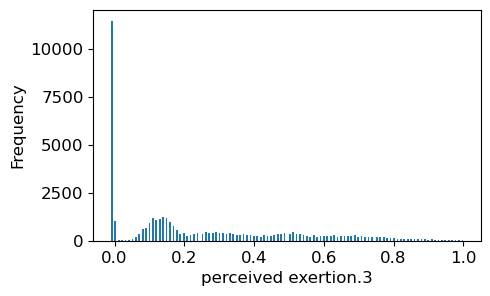

perceived trainingSuccess.3
count    730.000000
mean       0.398370
std        0.410747
min       -0.010000
25%        0.000000
50%        0.355000
75%        0.837500
max        0.980000
Name: perceived trainingSuccess.3, dtype: float64


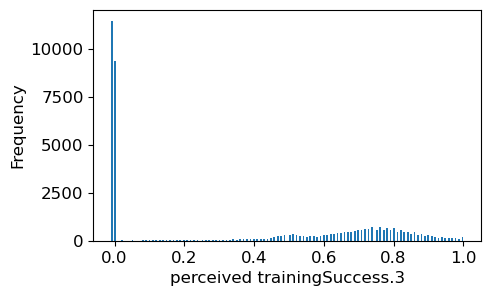

perceived recovery.3
count    730.000000
mean       0.136945
std        0.106660
min       -0.010000
25%        0.060000
50%        0.160000
75%        0.190000
max        0.570000
Name: perceived recovery.3, dtype: float64


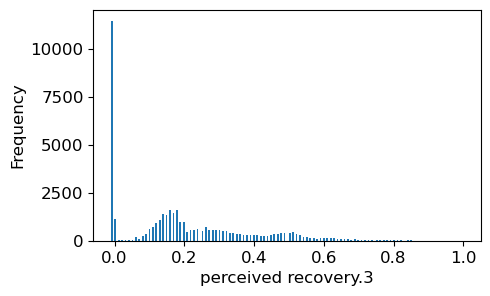

nr. sessions.4
count    730.000000
mean       0.879452
std        0.538493
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.4, dtype: float64


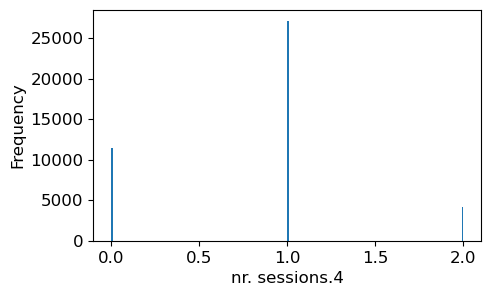

total km.4
count    730.000000
mean       5.372877
std        4.967467
min        0.000000
25%        0.000000
50%        5.800000
75%        8.700000
max       45.800000
Name: total km.4, dtype: float64


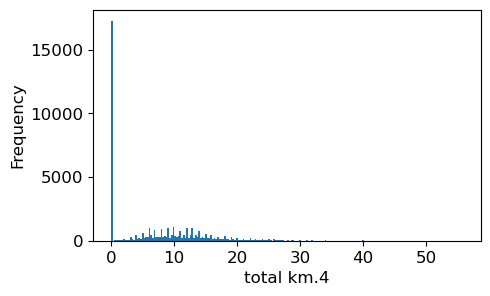

km Z3-4.4
count    730.000000
mean       0.429589
std        1.347385
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.000000
Name: km Z3-4.4, dtype: float64


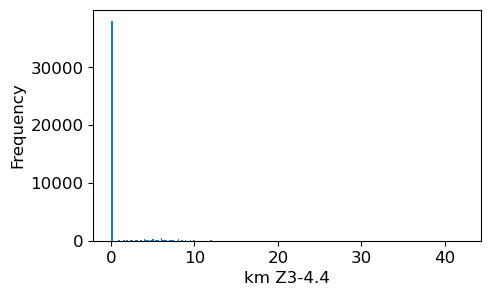

km Z5-T1-T2.4
count    730.000000
mean       0.328493
std        1.040317
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: km Z5-T1-T2.4, dtype: float64


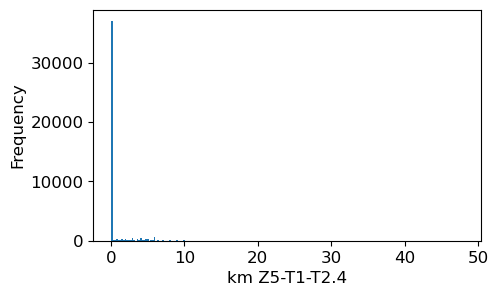

km sprinting.4
count    730.000000
mean       0.153288
std        0.435681
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.600000
Name: km sprinting.4, dtype: float64


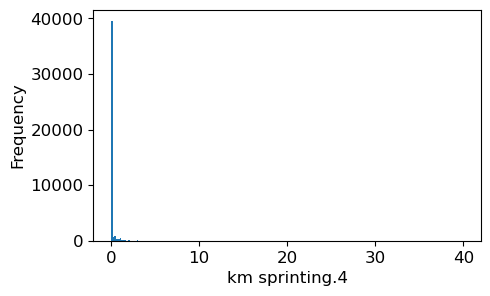

strength training.4
count    730.000000
mean       0.127397
std        0.361281
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.4, dtype: float64


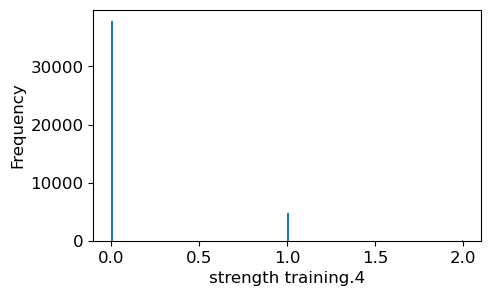

hours alternative.4
count    730.000000
mean       0.190151
std        0.493474
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.830000
Name: hours alternative.4, dtype: float64


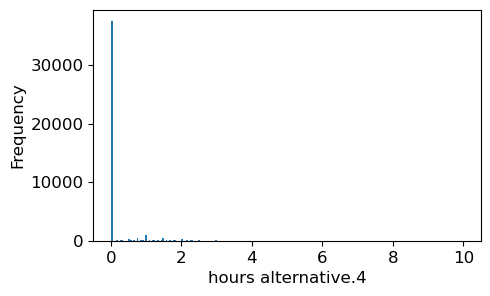

perceived exertion.4
count    730.000000
mean       0.213986
std        0.232249
min       -0.010000
25%        0.052500
50%        0.110000
75%        0.370000
max        1.000000
Name: perceived exertion.4, dtype: float64


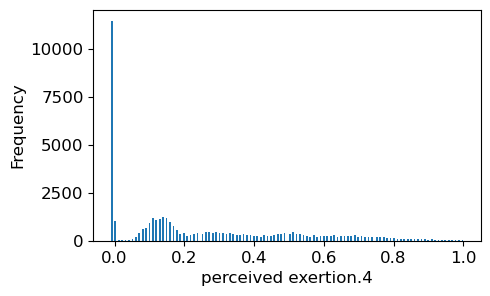

perceived trainingSuccess.4
count    730.000000
mean       0.392836
std        0.409310
min       -0.010000
25%        0.000000
50%        0.245000
75%        0.830000
max        0.980000
Name: perceived trainingSuccess.4, dtype: float64


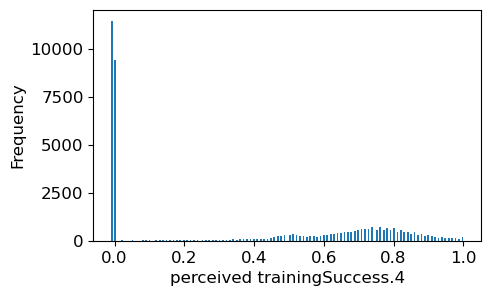

perceived recovery.4
count    730.000000
mean       0.135603
std        0.106501
min       -0.010000
25%        0.050000
50%        0.160000
75%        0.190000
max        0.570000
Name: perceived recovery.4, dtype: float64


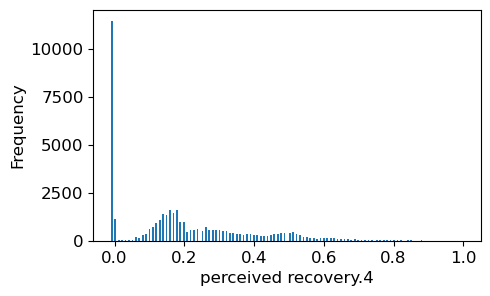

nr. sessions.5
count    730.000000
mean       0.879452
std        0.538493
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.5, dtype: float64


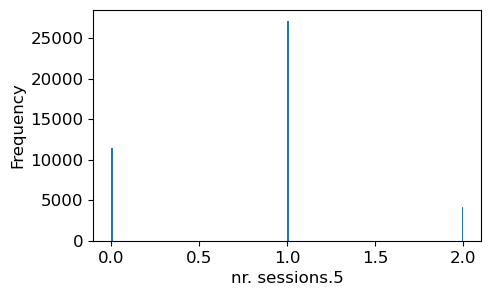

total km.5
count    730.000000
mean       5.473014
std        5.013977
min        0.000000
25%        0.000000
50%        5.800000
75%        8.975000
max       45.800000
Name: total km.5, dtype: float64


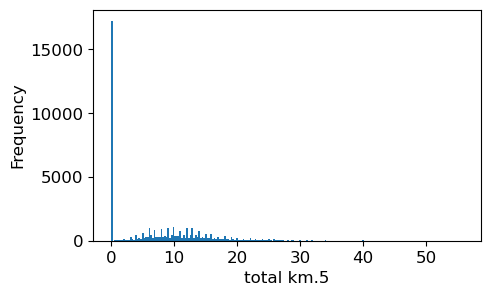

km Z3-4.5
count    730.000000
mean       0.436438
std        1.352136
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.000000
Name: km Z3-4.5, dtype: float64


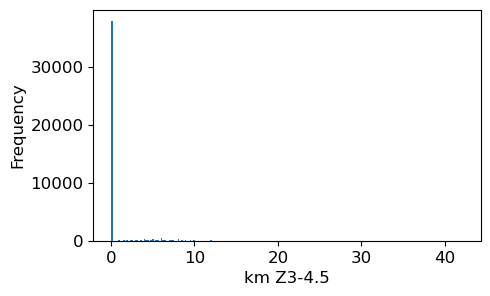

km Z5-T1-T2.5
count    730.000000
mean       0.368630
std        1.114299
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: km Z5-T1-T2.5, dtype: float64


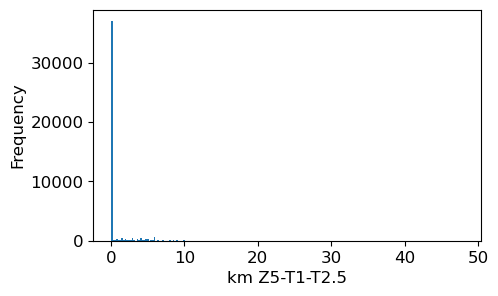

km sprinting.5
count    730.000000
mean       0.159178
std        0.472282
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.900000
Name: km sprinting.5, dtype: float64


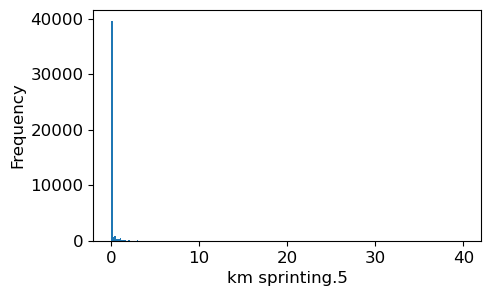

strength training.5
count    730.000000
mean       0.128767
std        0.362691
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.5, dtype: float64


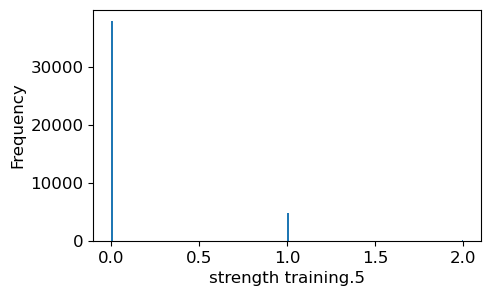

hours alternative.5
count    730.000000
mean       0.182616
std        0.487482
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.830000
Name: hours alternative.5, dtype: float64


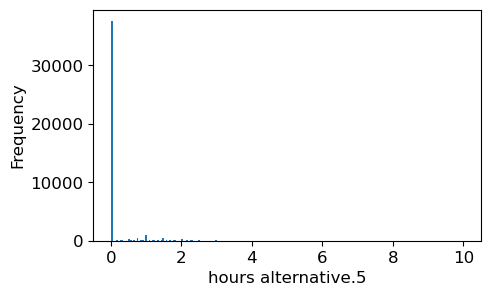

perceived exertion.5
count    730.000000
mean       0.216438
std        0.234405
min       -0.010000
25%        0.042500
50%        0.110000
75%        0.380000
max        1.000000
Name: perceived exertion.5, dtype: float64


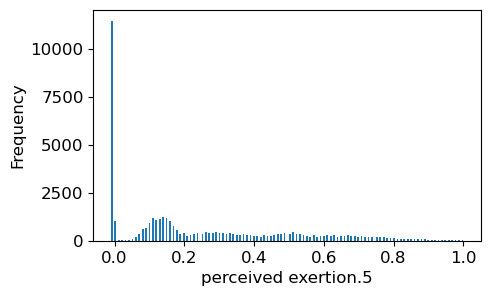

perceived trainingSuccess.5
count    730.000000
mean       0.395740
std        0.409973
min       -0.010000
25%        0.000000
50%        0.300000
75%        0.837500
max        0.990000
Name: perceived trainingSuccess.5, dtype: float64


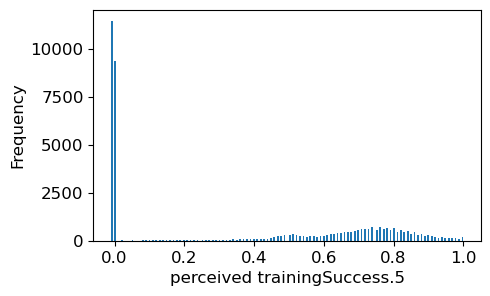

perceived recovery.5
count    730.000000
mean       0.136973
std        0.107939
min       -0.010000
25%        0.050000
50%        0.160000
75%        0.190000
max        0.750000
Name: perceived recovery.5, dtype: float64


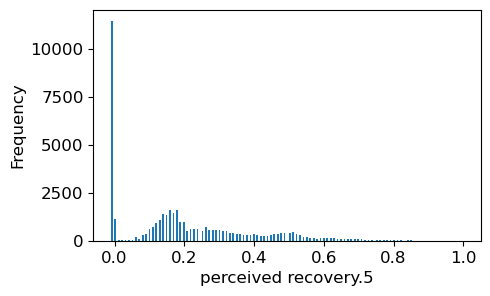

nr. sessions.6
count    730.000000
mean       0.886301
std        0.533594
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: nr. sessions.6, dtype: float64


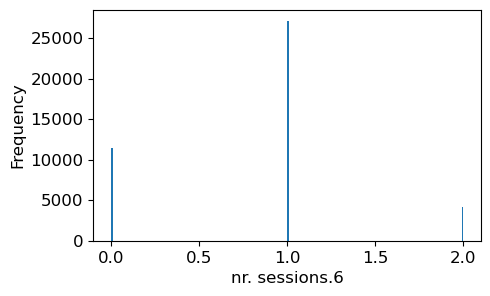

total km.6
count    730.000000
mean       5.376438
std        4.940412
min        0.000000
25%        0.000000
50%        5.800000
75%        8.700000
max       45.800000
Name: total km.6, dtype: float64


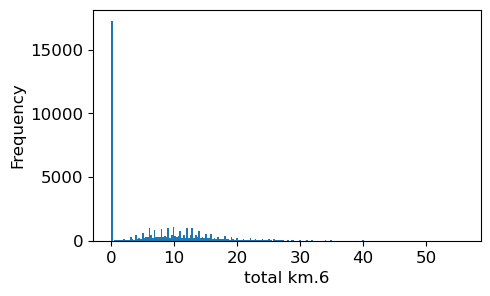

km Z3-4.6
count    730.000000
mean       0.443836
std        1.367112
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.000000
Name: km Z3-4.6, dtype: float64


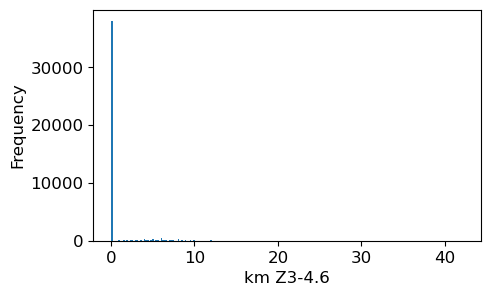

km Z5-T1-T2.6
count    730.000000
mean       0.337945
std        1.069209
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: km Z5-T1-T2.6, dtype: float64


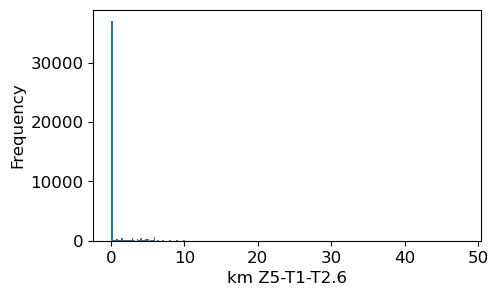

km sprinting.6
count    730.000000
mean       0.150411
std        0.419460
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.400000
Name: km sprinting.6, dtype: float64


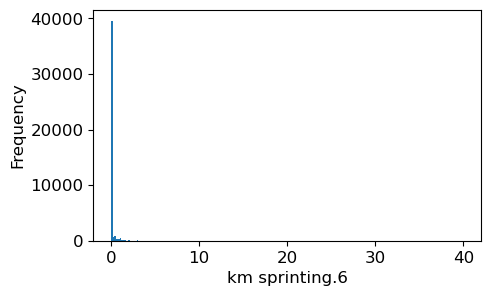

strength training.6
count    730.000000
mean       0.132877
std        0.366855
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: strength training.6, dtype: float64


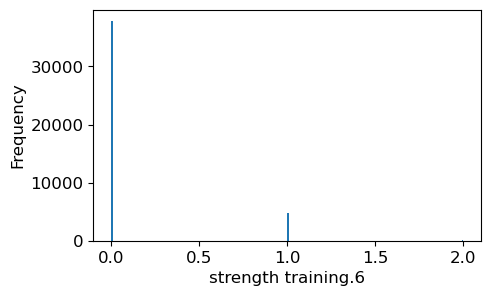

hours alternative.6
count    730.000000
mean       0.202260
std        0.520476
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.170000
Name: hours alternative.6, dtype: float64


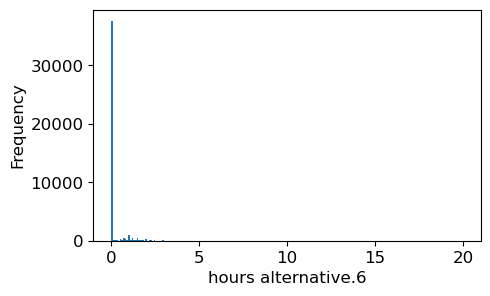

perceived exertion.6
count    730.000000
mean       0.220301
std        0.236544
min       -0.010000
25%        0.060000
50%        0.110000
75%        0.380000
max        1.000000
Name: perceived exertion.6, dtype: float64


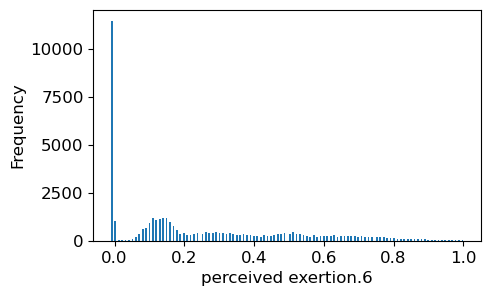

perceived trainingSuccess.6
count    730.000000
mean       0.399014
std        0.408471
min       -0.010000
25%        0.000000
50%        0.395000
75%        0.830000
max        0.980000
Name: perceived trainingSuccess.6, dtype: float64


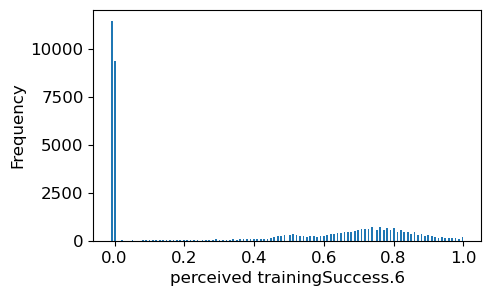

perceived recovery.6
count    730.000000
mean       0.139575
std        0.107532
min       -0.010000
25%        0.060000
50%        0.160000
75%        0.190000
max        0.750000
Name: perceived recovery.6, dtype: float64


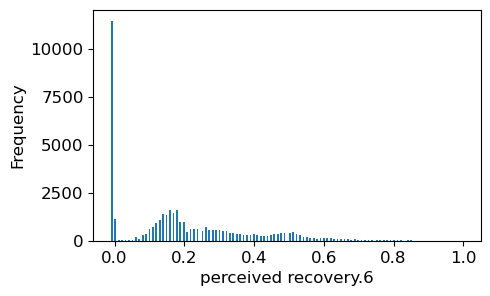

Athlete ID
count    730.0
mean      29.0
std        0.0
min       29.0
25%       29.0
50%       29.0
75%       29.0
max       29.0
Name: Athlete ID, dtype: float64


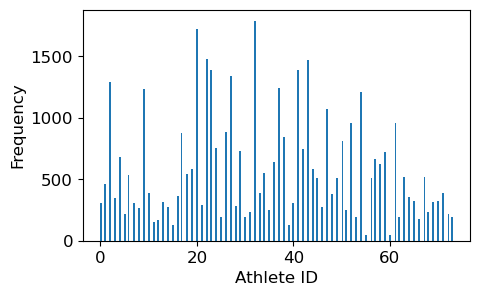

injury
count    730.000000
mean       0.045205
std        0.207897
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: injury, dtype: float64


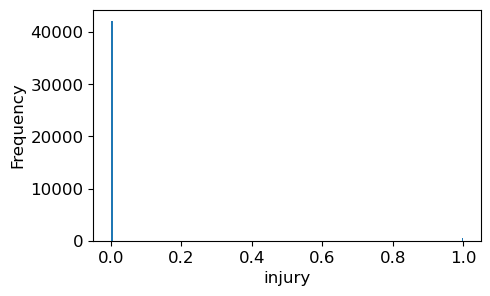

Date
count     730.000000
mean     1127.747945
std       900.112011
min         0.000000
25%       182.250000
50%       931.500000
75%      1710.750000
max      2651.000000
Name: Date, dtype: float64


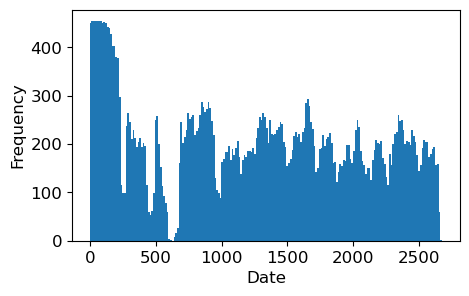

In [16]:
for ftr in df_29.columns:
    print(ftr)
    print(df_29[ftr].describe())
    plt.figure(figsize=(5,3))
    plt.hist(df_29[ftr], bins = int(np.sqrt(df.shape[0])))
    plt.xlabel(ftr)
    plt.ylabel('Frequency')
    #plt.savefig('../figures/{}.png'.format(ftr))
    plt.show()

count    730.000000
mean       5.383699
std        4.937621
min        0.000000
25%        0.000000
50%        5.900000
75%        8.800000
max       45.800000
Name: total km, dtype: float64


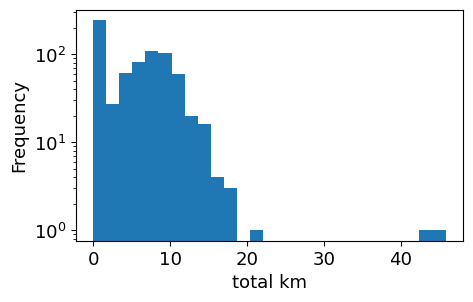

In [98]:
ftr = 'total km'
print(df_29[ftr].describe())
plt.figure(figsize=(5,3))
plt.hist(df_29[ftr], bins = int(np.sqrt(df_29.shape[0])))
plt.yscale('log')
plt.xlabel(ftr)
plt.ylabel('Frequency')
plt.savefig('../figures/{}.png'.format(ftr),bbox_inches='tight')
plt.show()

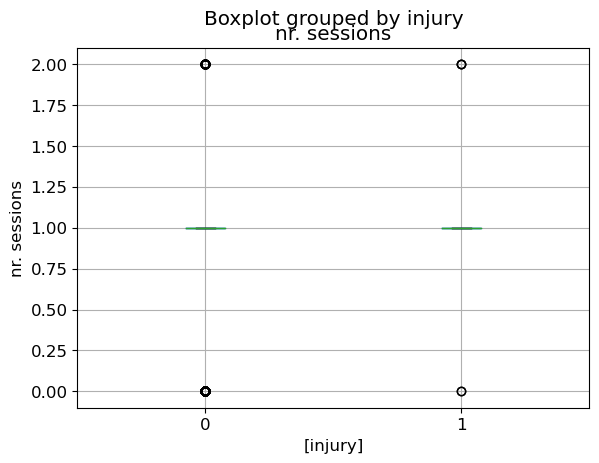

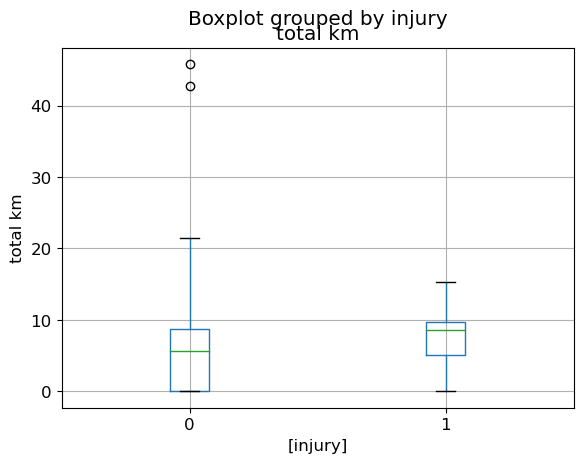

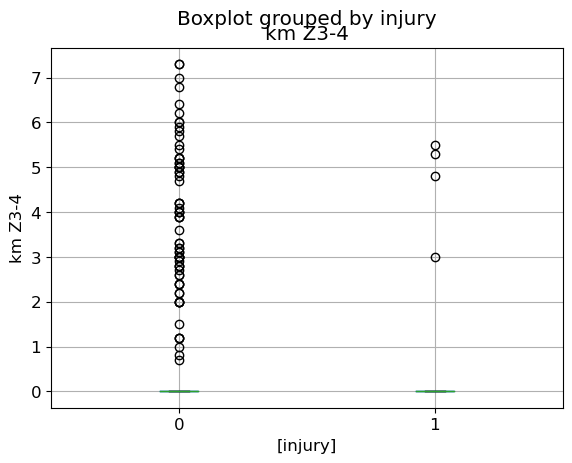

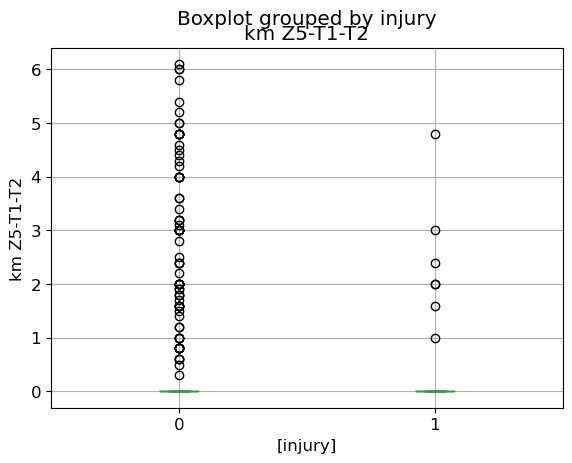

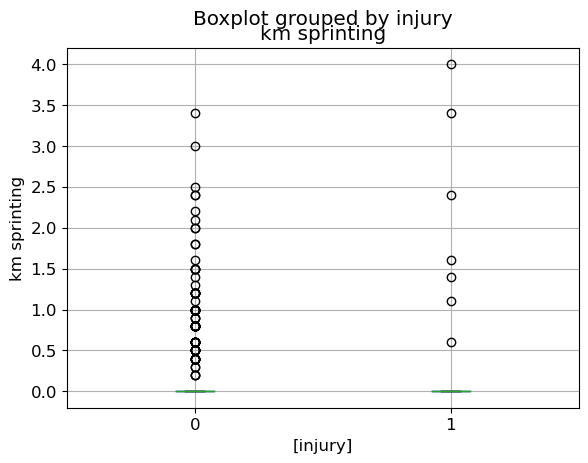

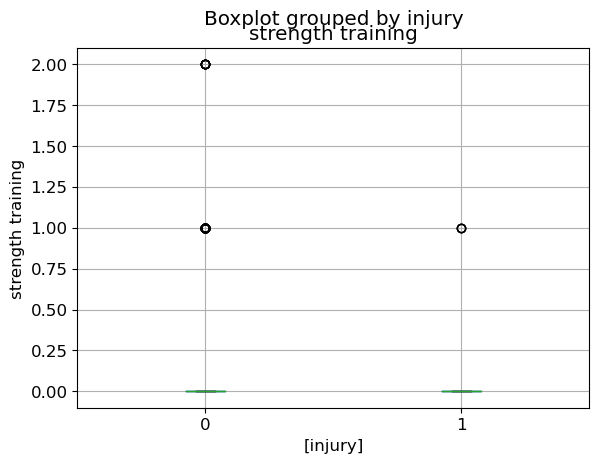

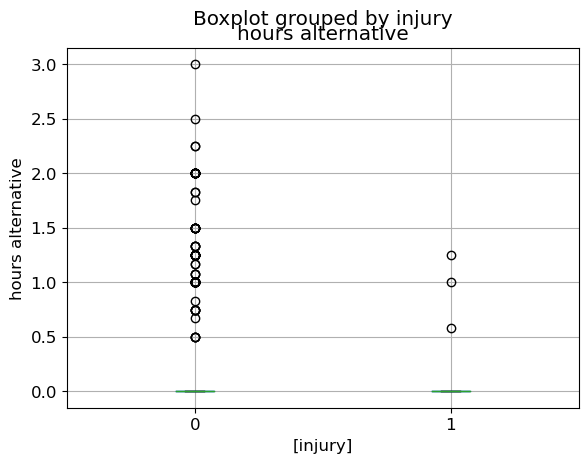

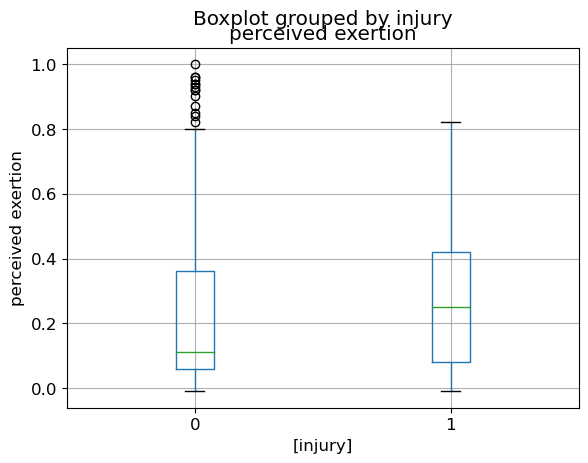

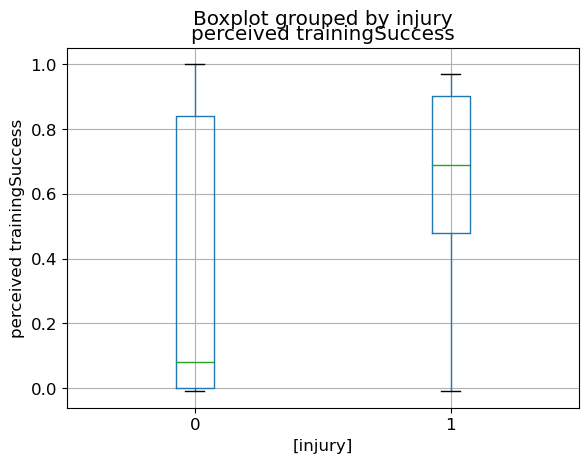

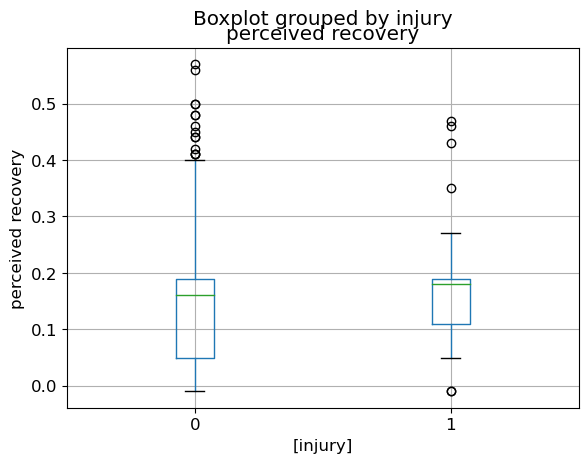

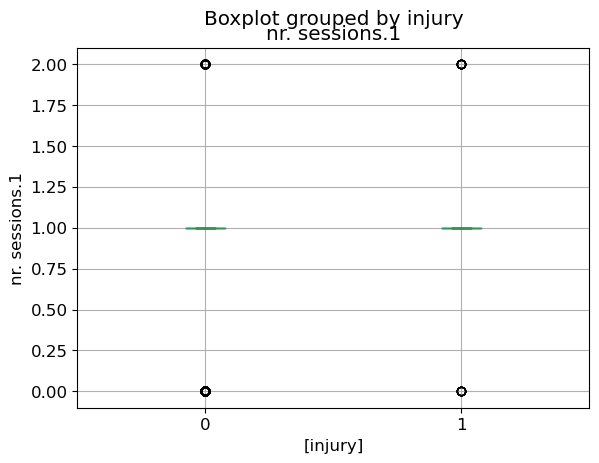

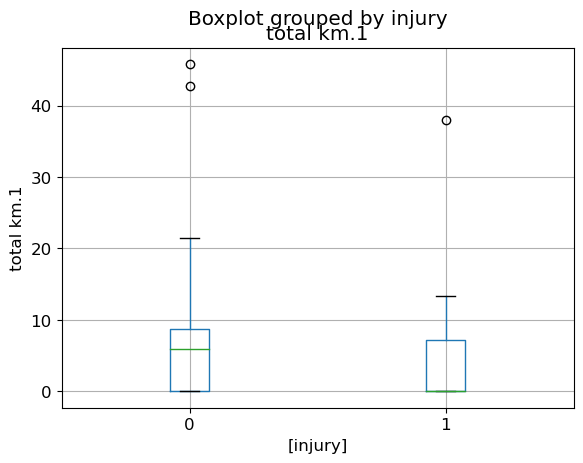

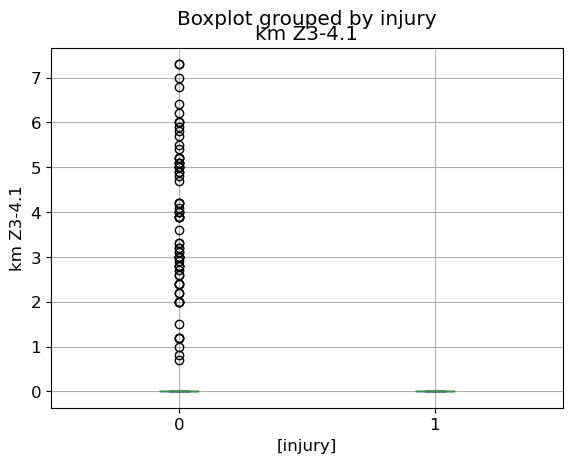

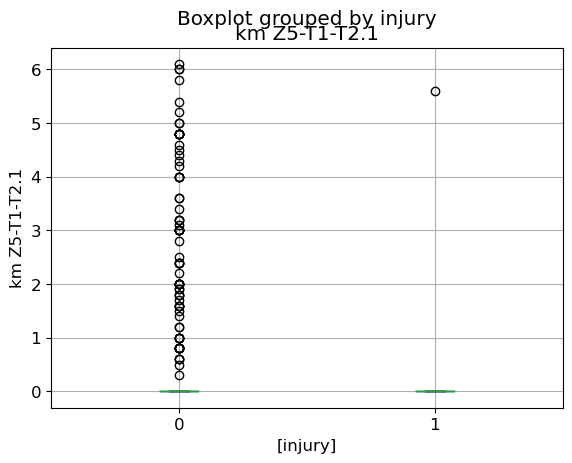

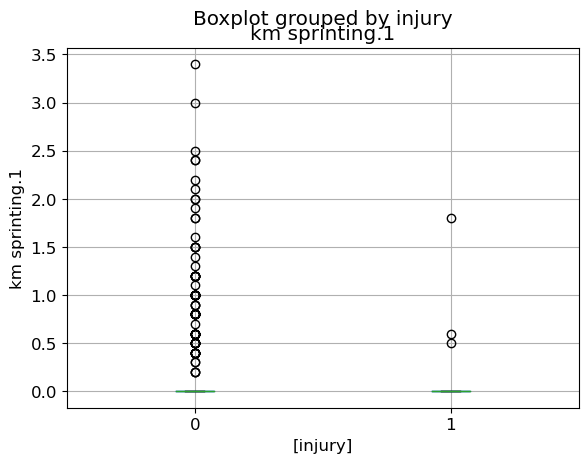

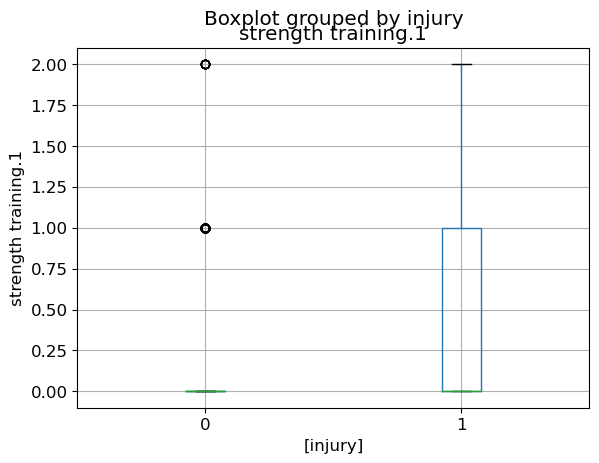

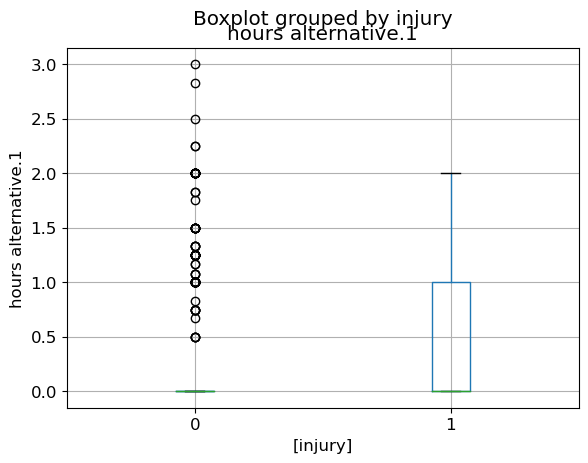

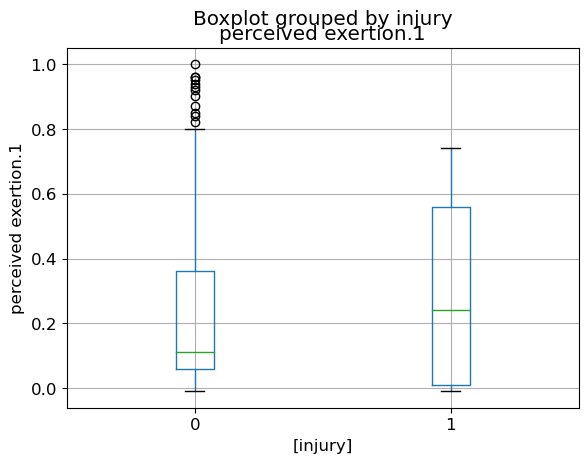

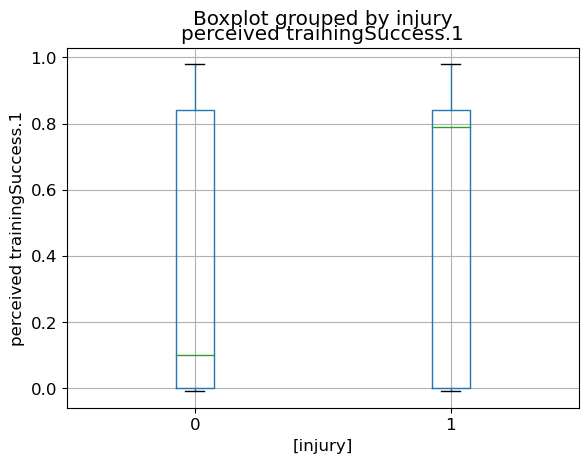

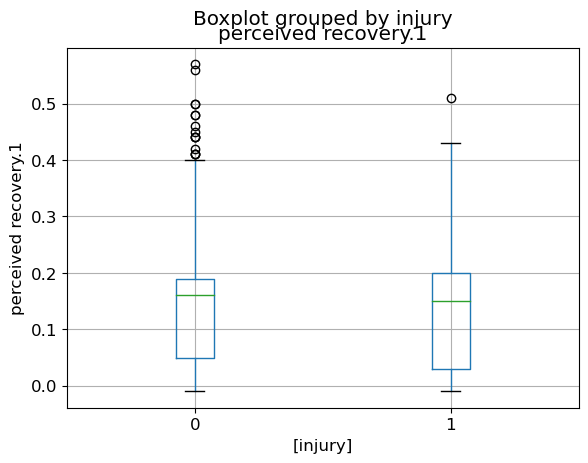

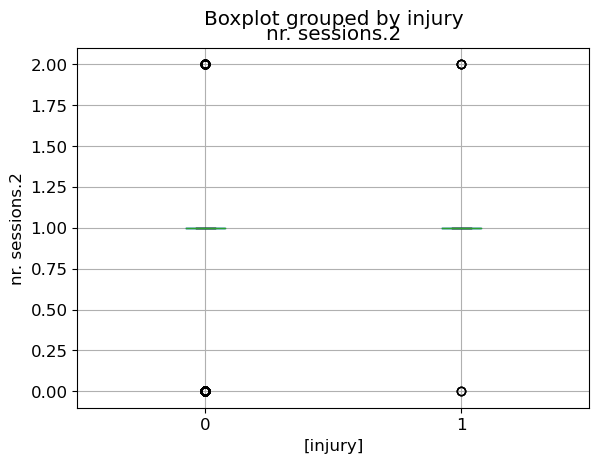

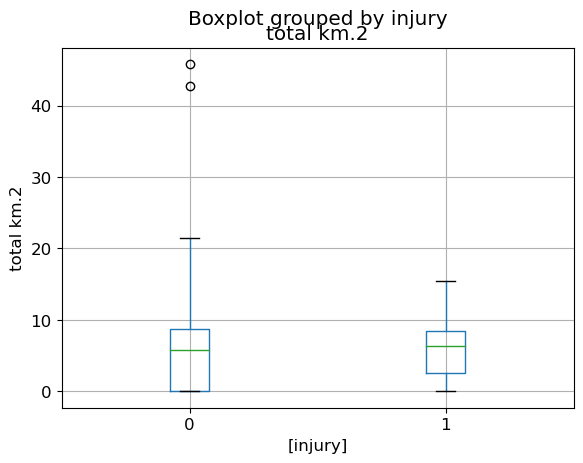

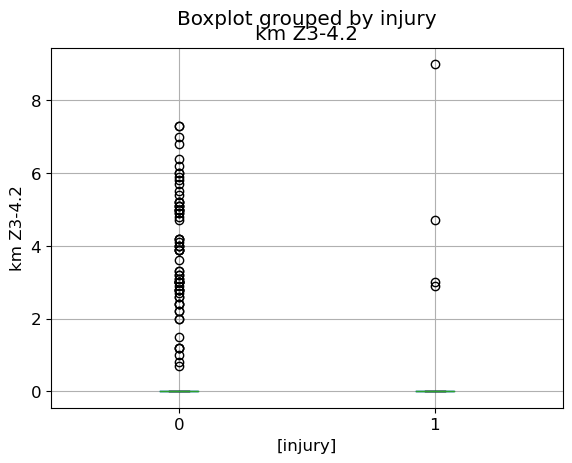

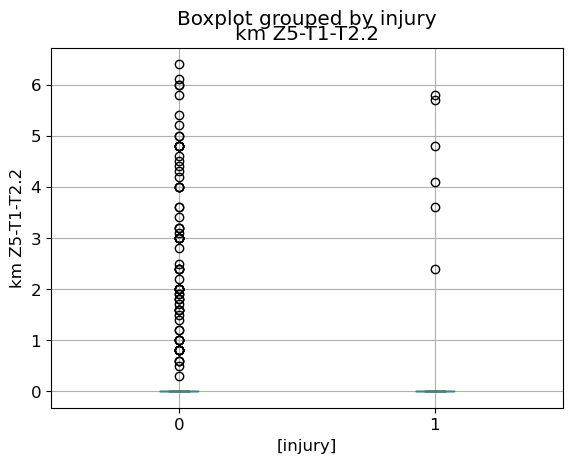

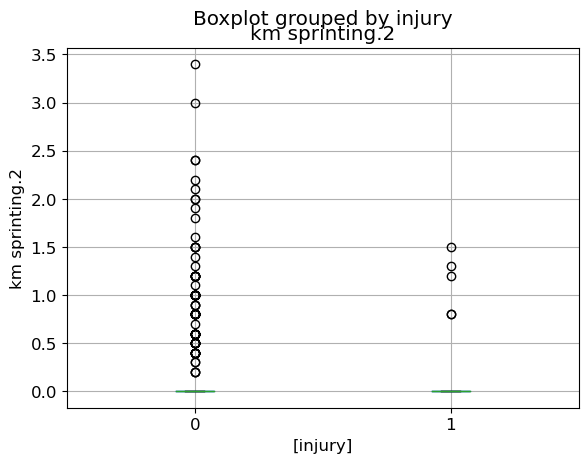

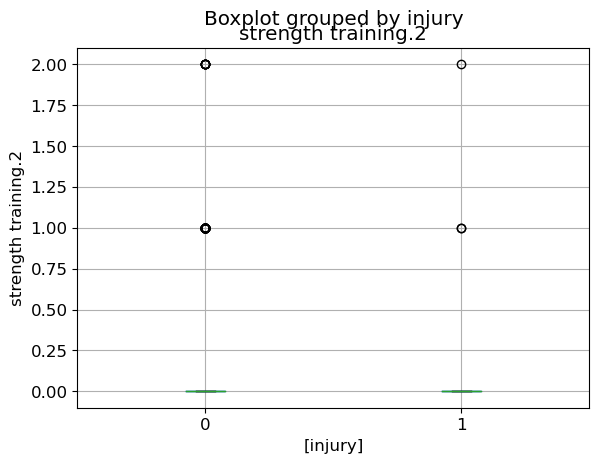

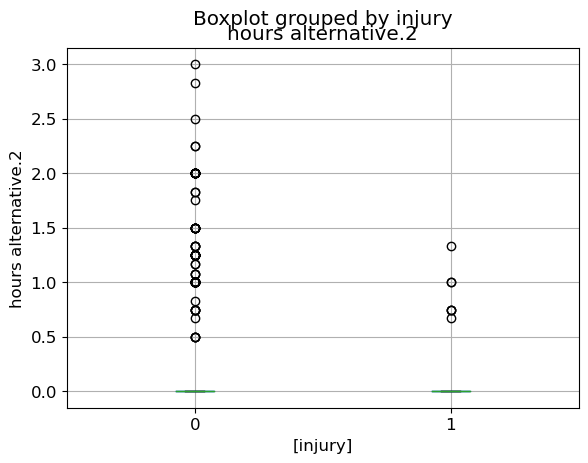

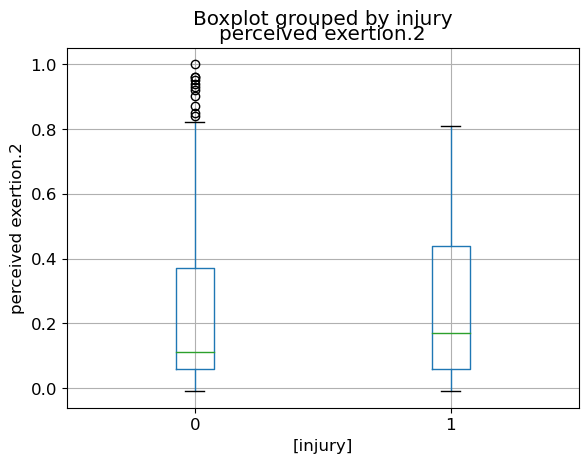

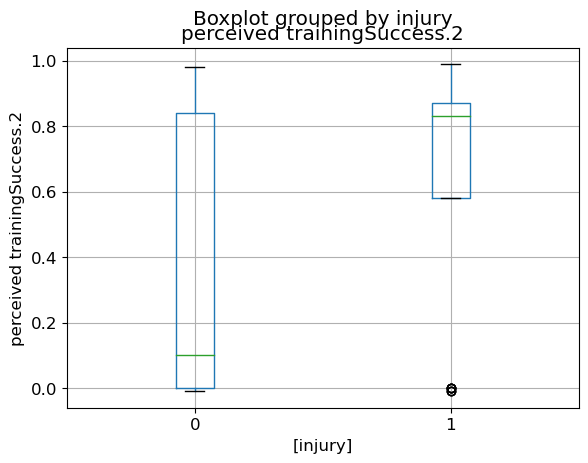

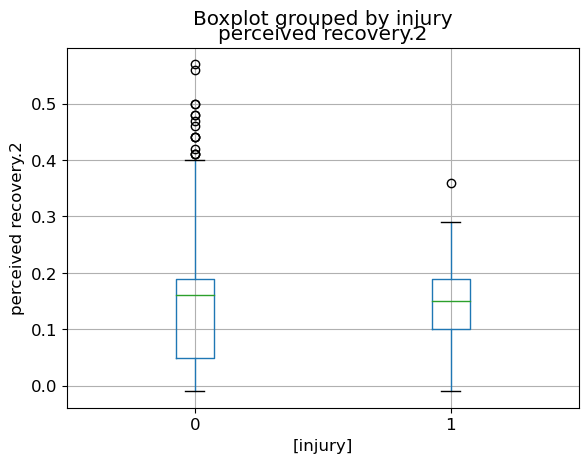

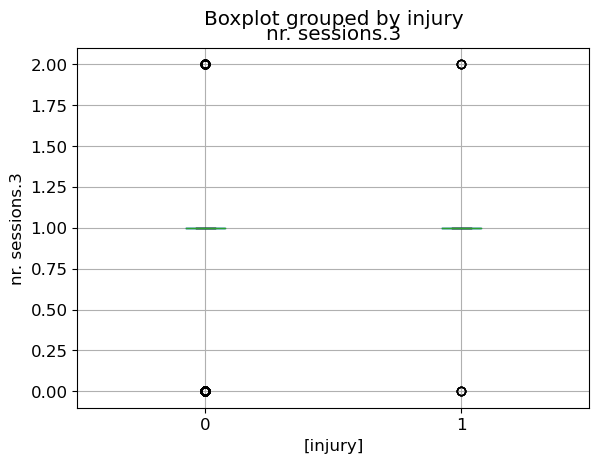

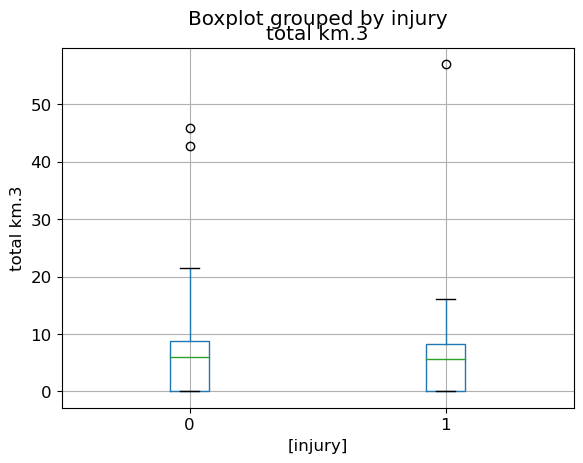

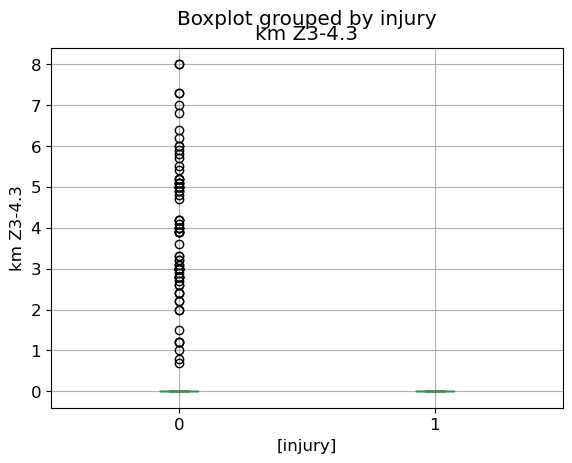

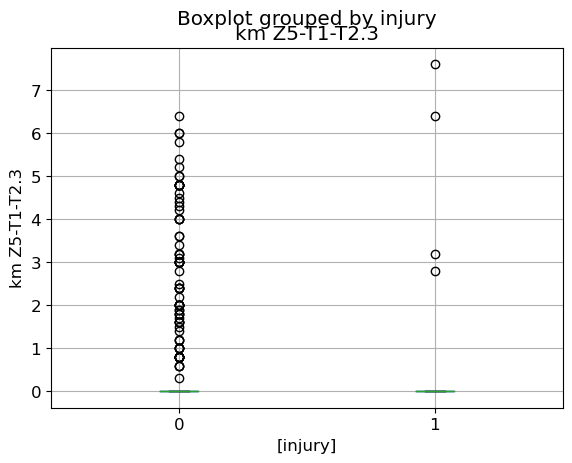

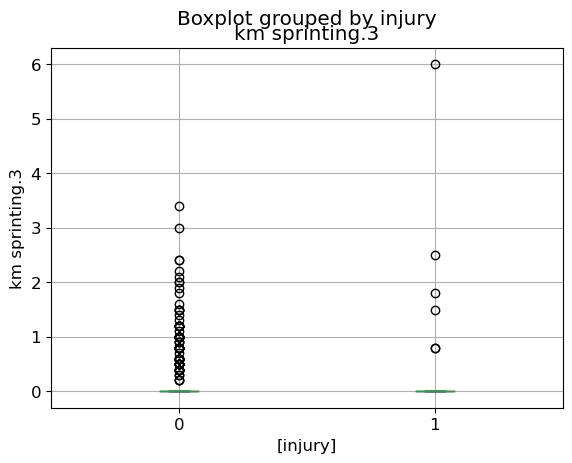

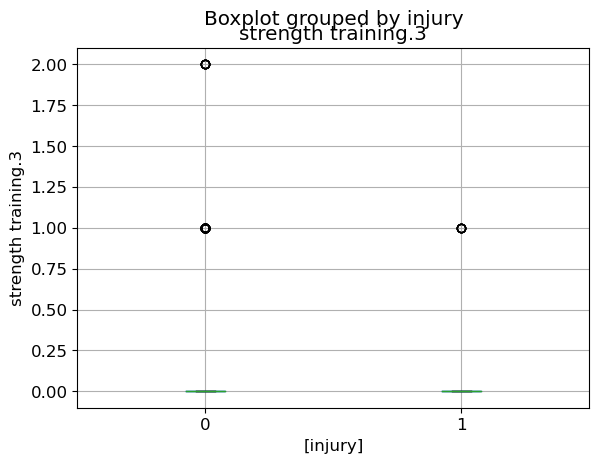

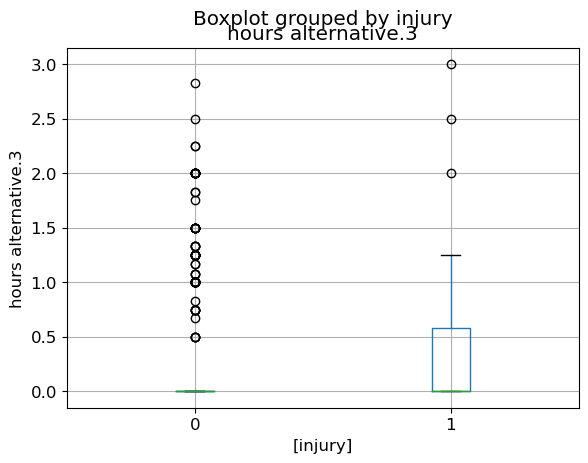

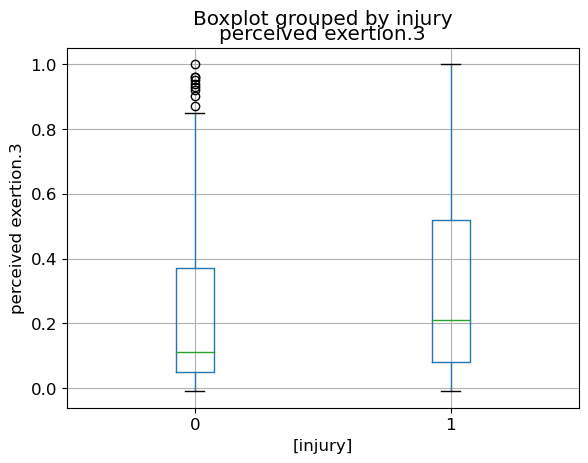

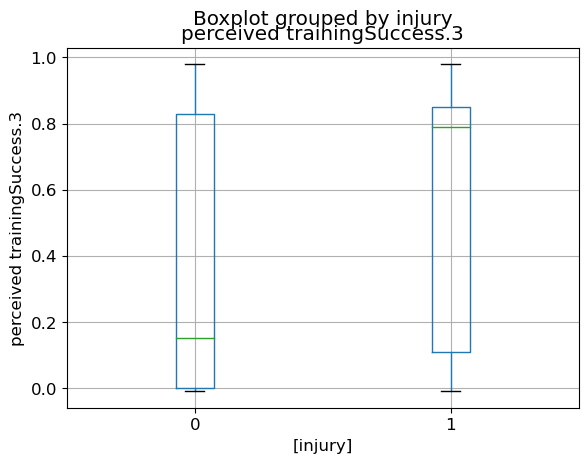

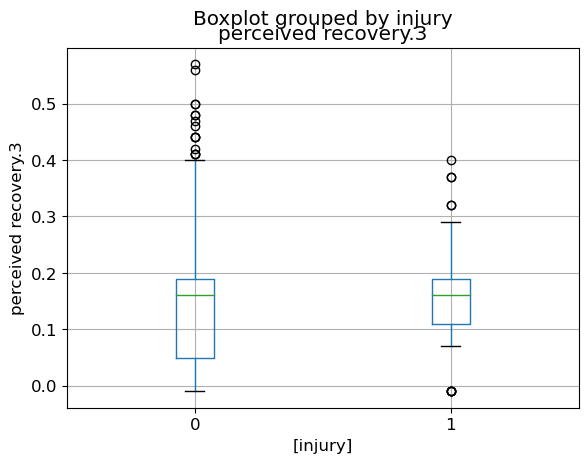

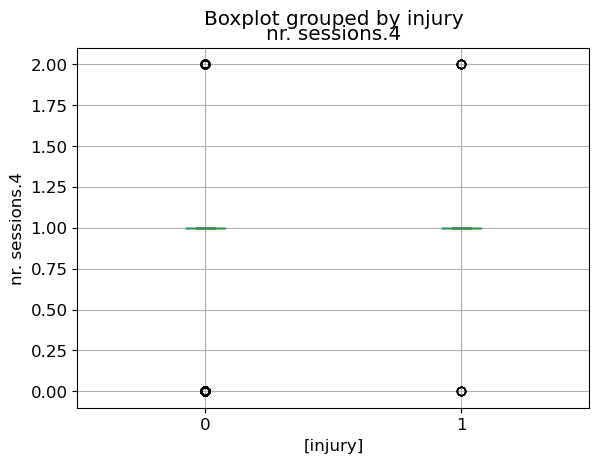

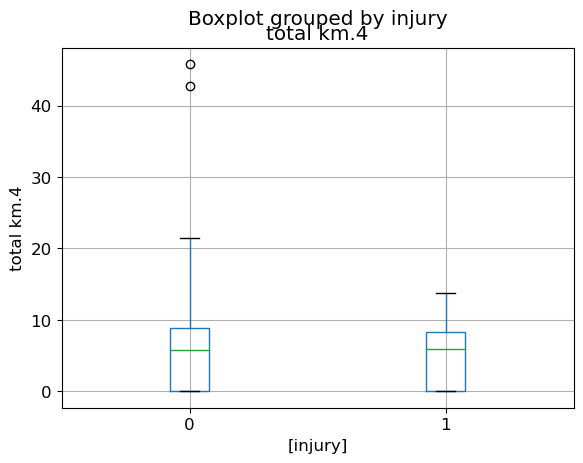

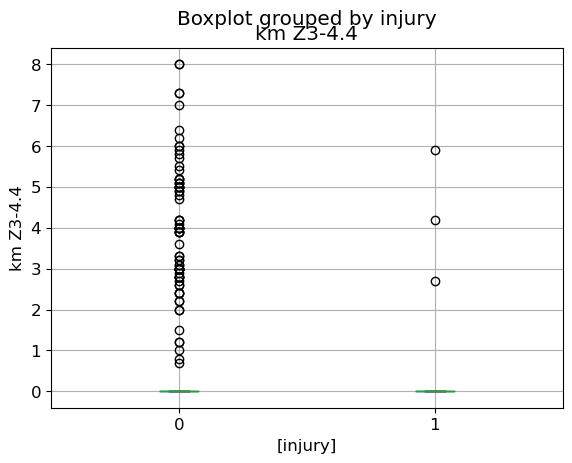

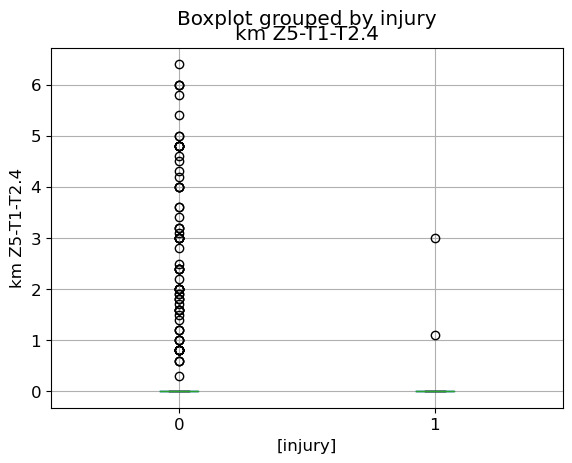

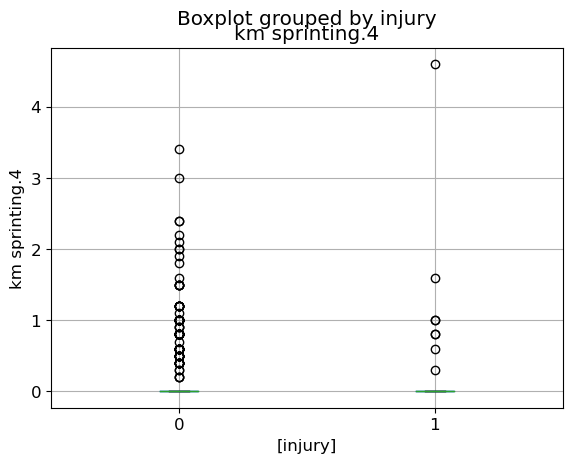

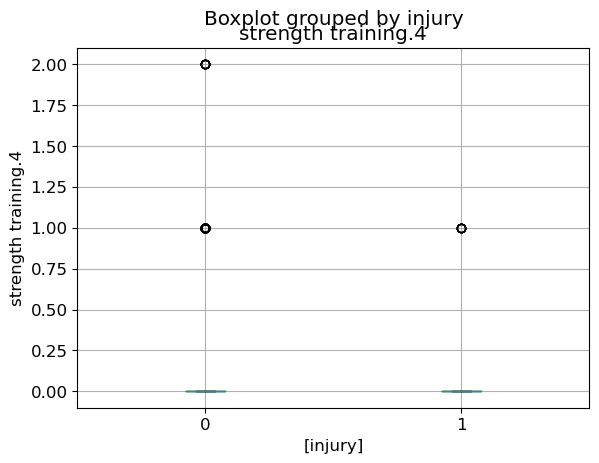

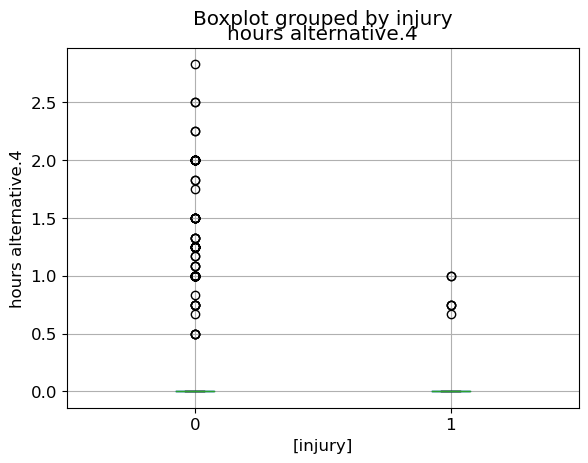

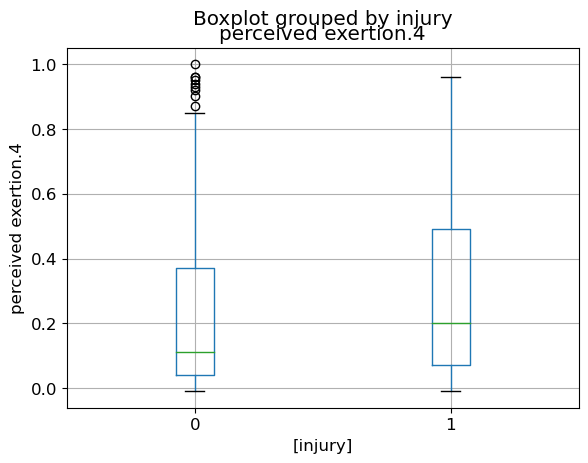

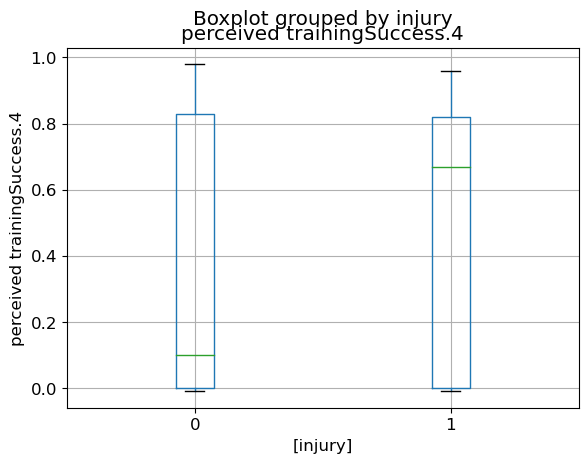

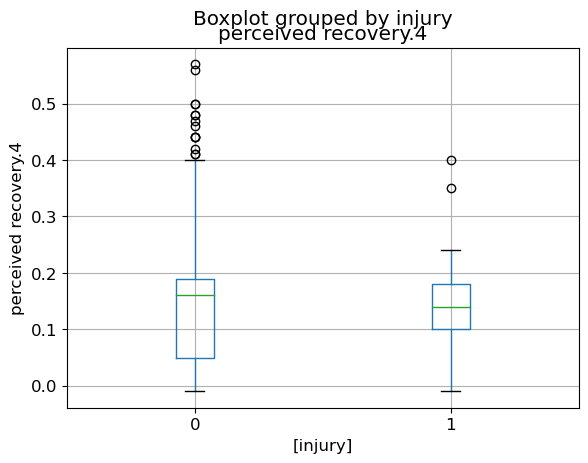

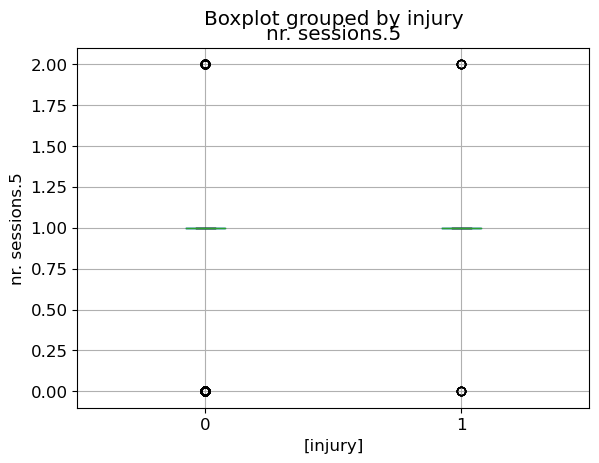

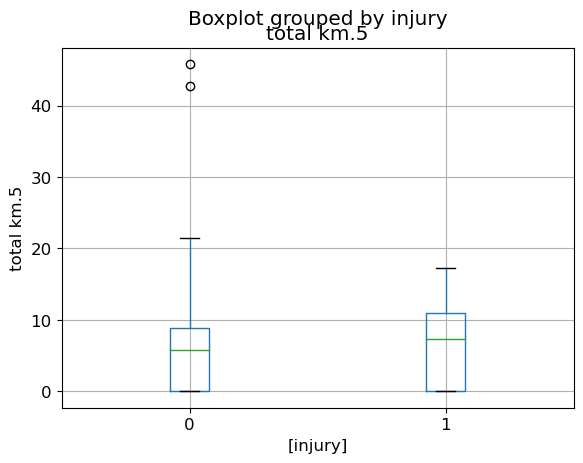

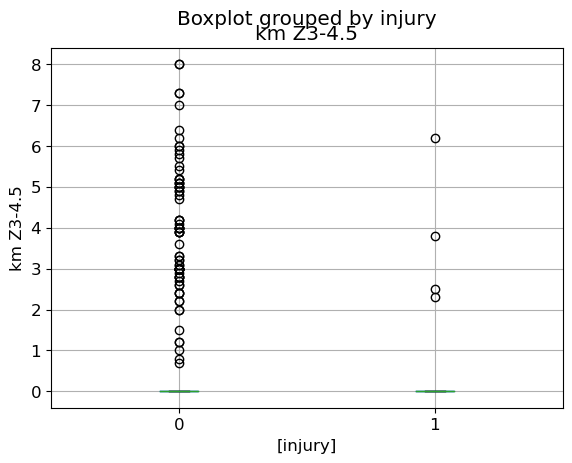

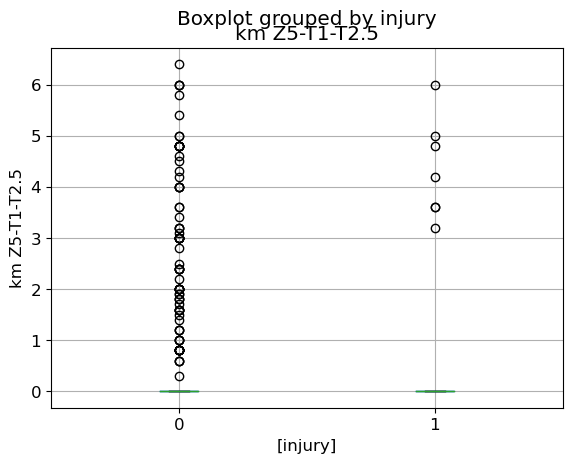

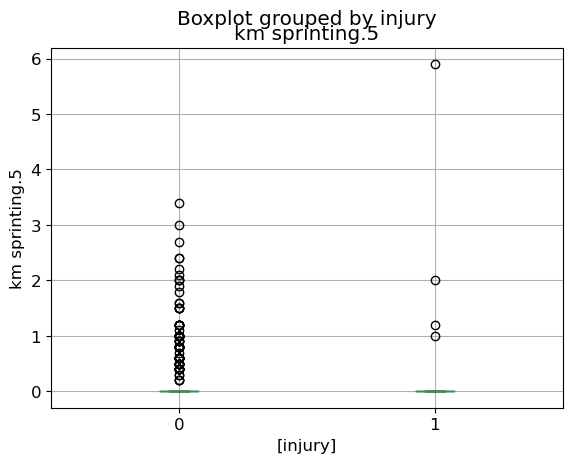

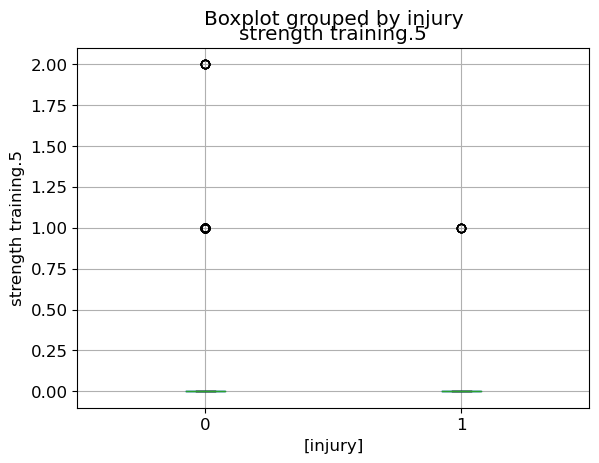

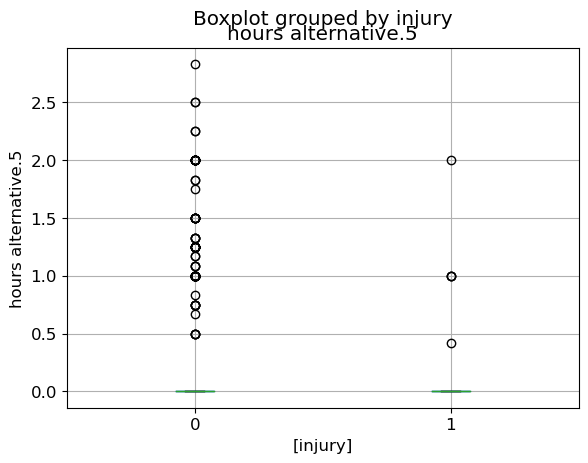

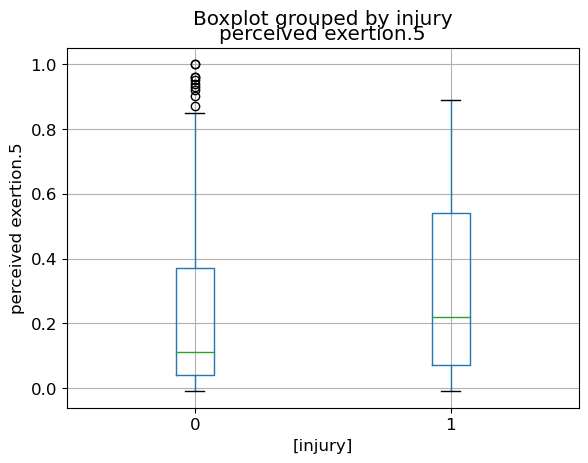

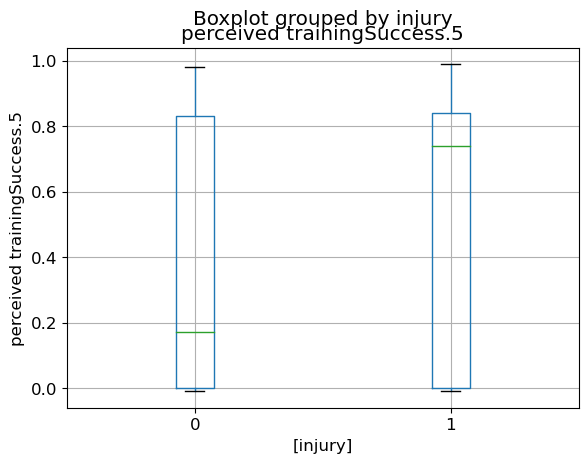

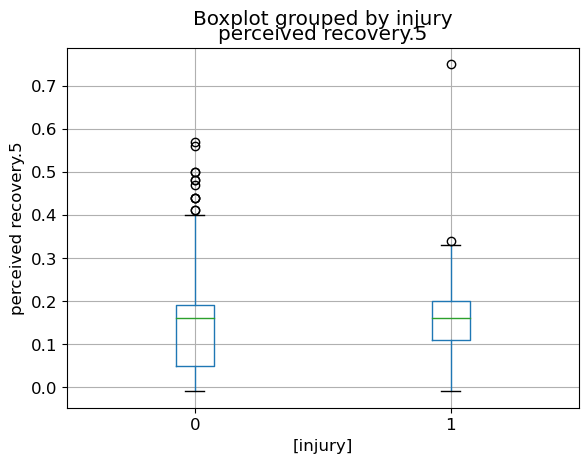

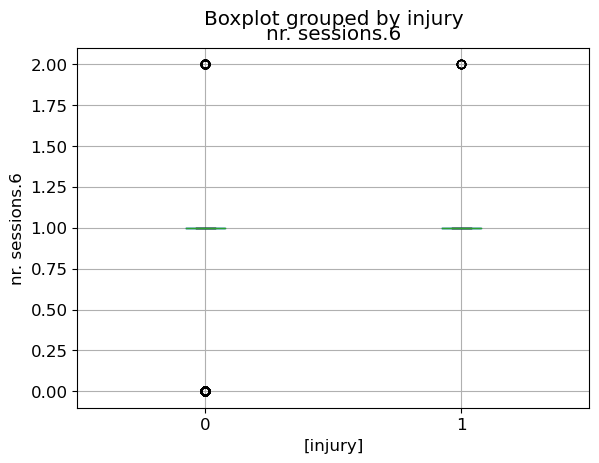

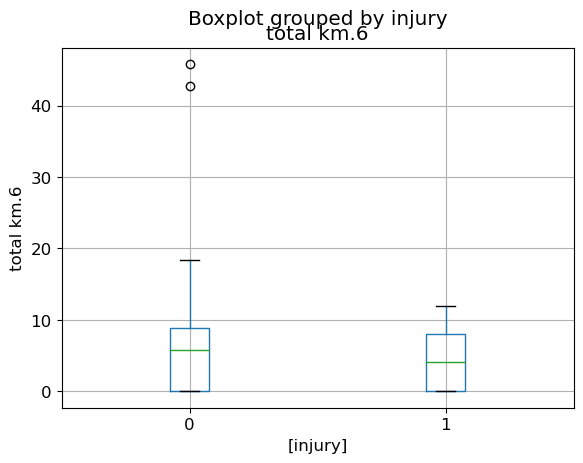

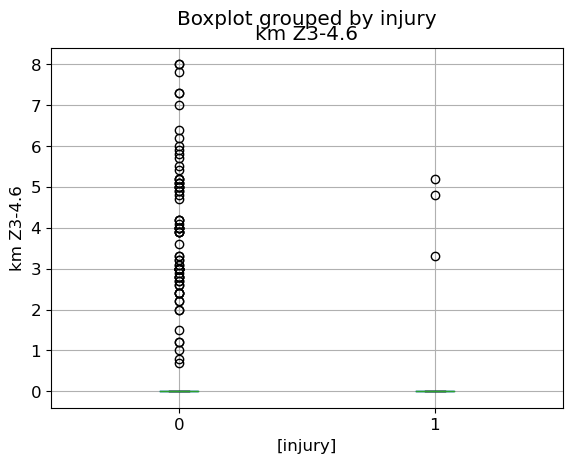

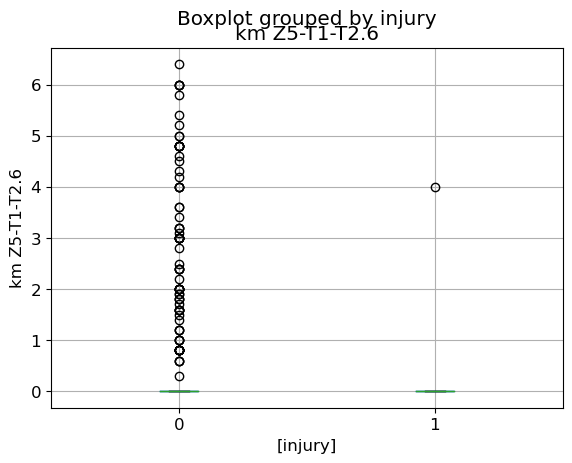

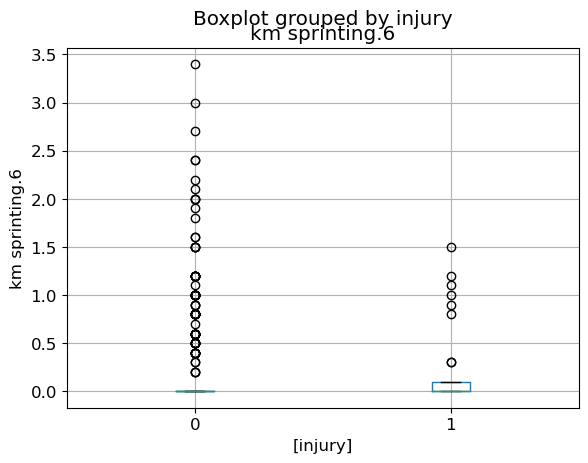

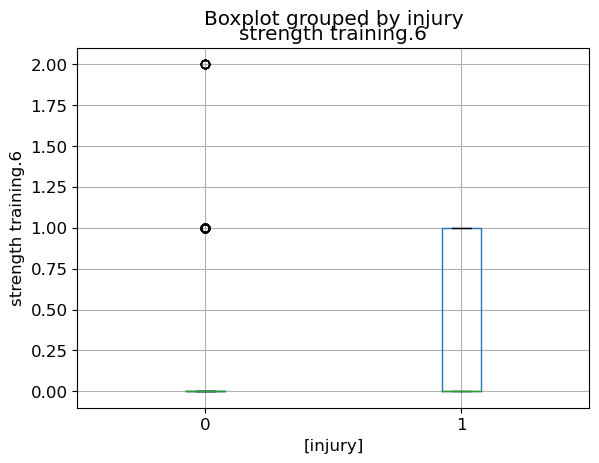

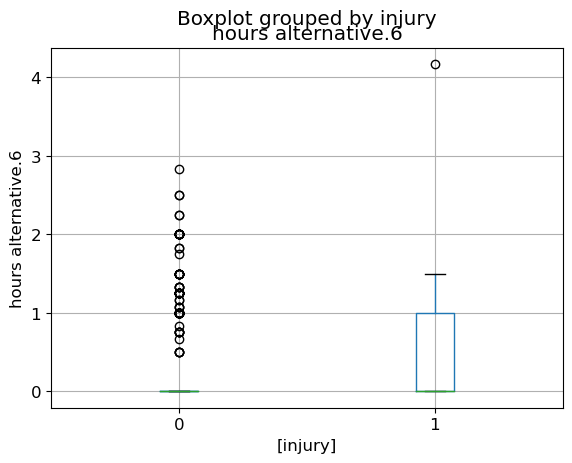

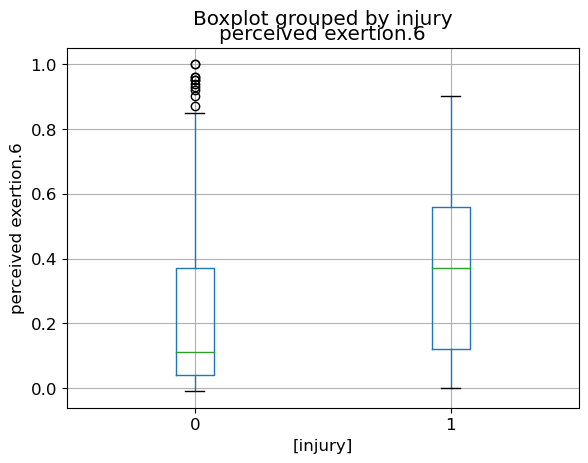

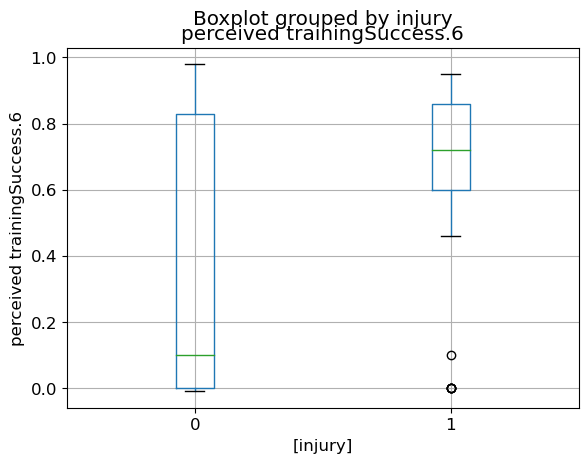

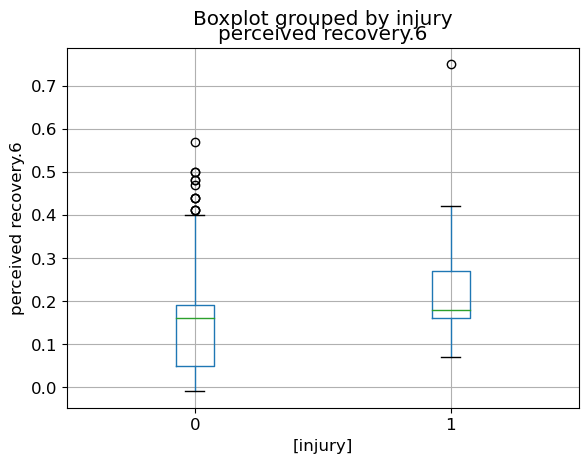

In [18]:
for ftr in cont_ftrs:
    df_29[[ftr,'injury']].boxplot(by = 'injury')
    plt.ylabel(ftr)
    #plt.savefig('../figures/{}-injury.png'.format(ftr))
    plt.show()

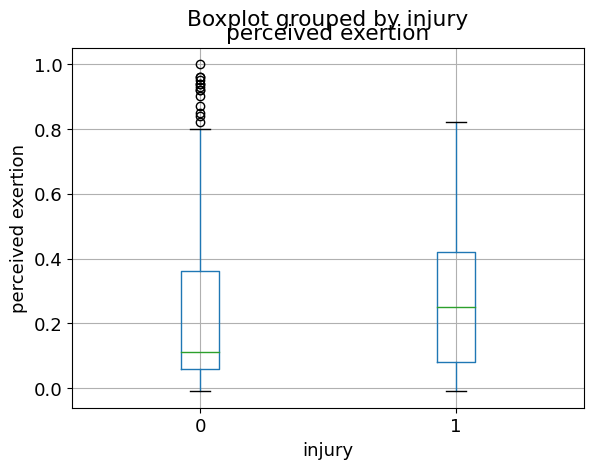

In [100]:
df_29[['perceived exertion','injury']].boxplot(by='injury')
plt.ylabel('perceived exertion')
plt.xlabel('injury')
plt.savefig('../figures/perceived_exertion-injury.png')
plt.show()

#### Correlation Matrix ####

In [514]:
df_29

nr. sessions  total km  km Z3-4  km Z5-T1-T2  km sprinting  \
1             1.0       8.6      2.0          2.0           0.0   
2             1.0       8.4      0.0          0.0           0.0   
3             1.0       9.7      1.2          1.0           0.0   
4             0.0       0.0      0.0          0.0           0.0   
5             1.0      10.2      0.0          2.4           0.4   
..            ...       ...      ...          ...           ...   
725           1.0      14.9      0.0          4.6           0.0   
726           1.0       0.0      0.0          0.0           0.0   
727           1.0      12.3      0.0          3.0           0.0   
728           2.0       6.2      0.0          0.0           0.0   
729           1.0      14.3      7.3          0.0           0.0   

     strength training  hours alternative  perceived exertion  \
1                  0.0                0.0                0.11   
2                  0.0                0.0                0.09   
3                  0.0                0.0                0.12   
4                  0.0                0.0               -0.01   
5                  0.0                0.0                0.14   
..                 ...                ...                 ...   
725                0.0                0.0                0.53   
726                1.0                1.0                0.48   
727                0.0                0.0                0.35   
728                1.0                1.0                0.49   
729                0.0                0.0                0.49   

     perceived trainingSuccess  perceived recovery  ...  \
1                         0.00                0.18  ...   
2                         0.00                0.17  ...   
3                         0.00                0.19  ...   
4                        -0.01               -0.01  ...   
5                         0.00                0.18  ...   
..                         ...                 ...  ...   
725                       0.57                0.10  ...   
726                       0.88                0.05  ...   
727                       0.59                0.31  ...   
728                       0.86                0.12  ...   
729                       0.81                0.10  ...   

     ave hours alternative  ave perceived exertion  \
1                 0.000000                0.091429   
2                 0.000000                0.088571   
3                 0.000000                0.092857   
4                 0.000000                0.074286   
5                 0.000000                0.090000   
..                     ...                     ...   
725               0.642857                0.460000   
726               0.642857                0.444286   
727               0.857143                0.444286   
728               0.857143                0.428571   
729               0.928571                0.432857   

     ave perceived trainingSuccess  ave perceived recovery  max total km  \
1                        -0.001429                0.151429          11.8   
2                        -0.001429                0.151429          11.8   
3                        -0.001429                0.152857          11.8   
4                        -0.002857                0.124286          11.8   
5                        -0.001429                0.152857          11.8   
..                             ...                     ...           ...   
725                       0.747143                0.137143          14.9   
726                       0.760000                0.132857          14.3   
727                       0.760000                0.152857          14.3   
728                       0.800000                0.115714          14.3   
729                       0.794286                0.121429          14.3   

     max km Z3-4  max km Z5-T1-T2  max km sprinting  max hours alternative  \
1            2.0              2.4               0.4                   

In [20]:
df_29 = df_29.sort_values(by = 'Date')
df_29.reset_index(inplace=True, drop=True)
df_29[df_29['injury'] == 1]

nr. sessions  total km  km Z3-4  km Z5-T1-T2  km sprinting  \
224           1.0      12.6      0.0          0.0           0.6   
238           1.0      14.8      0.0          0.0           0.0   
239           1.0       9.7      0.0          2.0           0.0   
240           1.0       5.1      0.0          0.0           0.0   
268           1.0       7.3      0.0          1.6           0.0   
269           1.0       7.6      0.0          0.0           0.0   
270           1.0       8.0      3.0          0.0           0.0   
271           1.0      15.3      4.8          0.0           0.0   
272           1.0       8.7      0.0          0.0           0.0   
277           2.0      14.5      0.0          0.0           0.0   
372           1.0       9.1      0.0          0.0           1.6   
373           1.0       0.0      0.0          0.0           0.0   
401           1.0       9.7      0.0          3.0           0.0   
402           1.0       9.0      0.0          0.0           4.0   
444           1.0       9.9      0.0          4.8           0.0   
452           1.0       7.5      0.0          0.0           2.4   
453           1.0       9.0      0.0          0.0           0.0   
467           1.0       7.6      0.0          2.4           0.0   
468           1.0       0.0      0.0          0.0           0.0   
469           0.0       0.0      0.0          0.0           0.0   
470           1.0       3.5      0.0          0.0           0.0   
551           1.0       8.6      0.0          0.0           3.4   
552           1.0       9.2      0.0          1.0           0.0   
553           2.0      11.7      0.0          0.0           0.0   
590           0.0       0.0      0.0          0.0           0.0   
597           1.0       9.3      5.5          0.0           0.0   
598           1.0       9.3      0.0          2.0           0.0   
599           1.0       0.0      0.0          0.0           0.0   
600           1.0       5.6      0.0          0.0           0.0   
601           1.0       4.2      0.0          0.0           1.1   
624           1.0      14.6      5.3          0.0           0.0   
625           2.0       0.0      0.0          0.0           0.0   
633           1.0       5.9      0.0          0.0           1.4   

     strength training  hours alternative  perceived exertion  \
224                0.0               0.00                0.11   
238                0.0               0.00                0.08   
239                0.0               0.00                0.12   
240                0.0               0.00                0.08   
268                0.0               0.00                0.14   
269                0.0               0.00                0.07   
270                0.0               0.00                0.71   
271                0.0               0.00                0.14   
272                0.0               0.00                0.10   
277                0.0               0.00                0.68   
372                0.0               0.00                0.36   
373                1.0               0.00                0.36   
401                0.0               0.00                0.05   
402                0.0               0.00                0.30   
444                0.0               0.00                0.35   
452                0.0               0.00                0.64   
453                0.0               0.00                0.00   
467                0.0               0.00                0.66   
468                0.0               1.25                0.24   
469                0.0               0.00               -0.01   
470                0.0               0.00                0.07   
551                0.0               0.00                0.42   
552                0.0               0.00                0.07   
553                0.0               1.00                0.34   
590                0.0               0.00               -0.01   
597                0.0              

### Feature Engineering: ###


In [107]:
df_29 = df_29.replace(-1,0)

In [109]:
columns = df_29.columns

In [110]:
col_names = ['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery']
minmax_names = ['total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting','hours alternative']
for col_name in col_names:
    df_29['ave {}'.format(col_name)] = df_29[[col for col in columns if col.startswith(col_name)]].mean(axis=1)

for col_name in minmax_names:   
    df_29['max {}'.format(col_name)] = df_29[[col for col in columns if col.startswith(col_name)]].max(axis=1)



In [182]:
df_29['injury_lag_1'] = df_29['injury'].shift(1)
df_29.drop(index=0,inplace=True)

In [472]:
df_29 = df_29.sort_values(by = 'Date')
X = df_29[[col for col in df_29.columns if col.startswith('ave') or col in col_names or col.startswith('max') or col == 'injury_lag_1']]
y = df_29['injury']


### Splitting Data ###

### Preprocessing Data ###



### Build a pipeline to transform data and train models

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score, make_scorer
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import pickle


In [378]:
other_ftrs = ['injury_lag_1']

# use standard scaler for other continuous variables
std_ftrs = [col for col in X]


#### Prepare column transformer ####

In [381]:
preprocessor = ColumnTransformer(
    transformers=[('std', StandardScaler(), std_ftrs)])


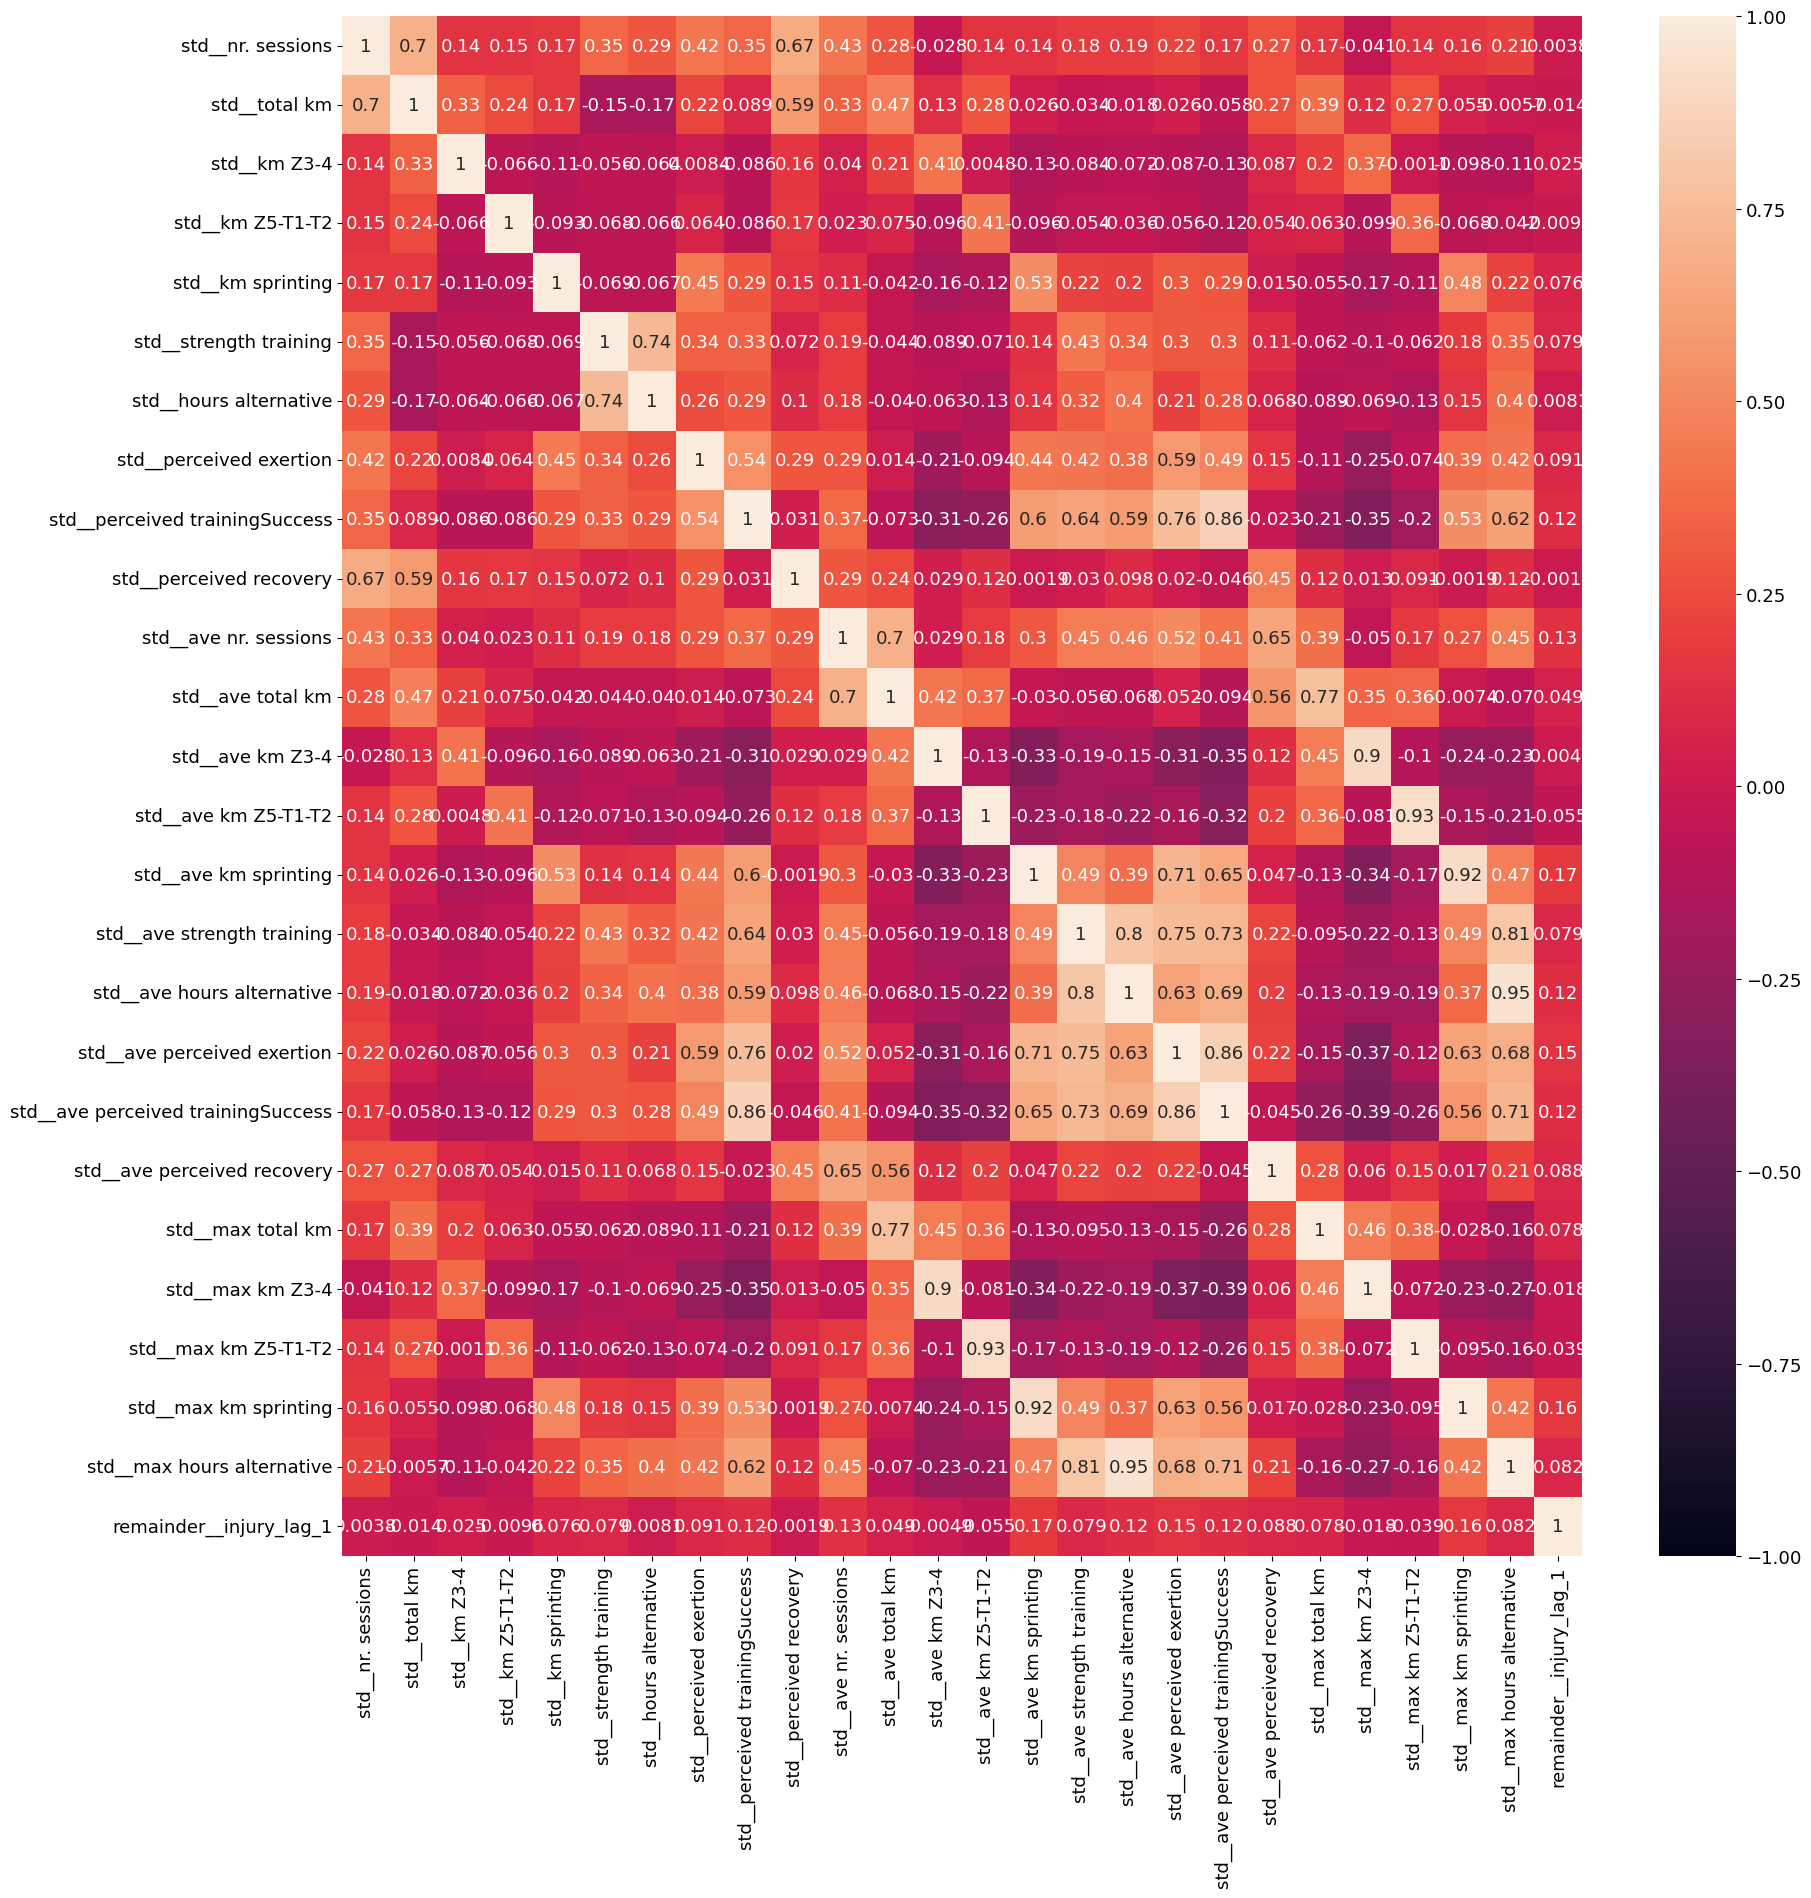

In [512]:
corr_matrix = X_train_prep.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,vmin=-1,vmax=1,annot=True)
plt.show()

### Training Models:

In [124]:
from sklearn.metrics import make_scorer

# make an f2 scorer

def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2, zero_division = 0)
    return f2_score

def my_f2_scorer():
    return make_scorer(f2_func)

In [257]:
# build the pipeline

def MLpipe(X, y, algo, param_grid):
    nr_states = 5
    
    injury_index = [idx for idx in y.index if y[idx] == 1]
    split_size = 5
    
    final_models = []
    final_test_scores = []
    X_test_sets = []
    y_test_sets = []
    
    for i in range(1,nr_states):
        models = []
        val_scores = []
        train_scores = []
        
        # split the data:
        train_val_split = injury_index[int(i*split_size)]
        val_test_split = injury_index[int((i+1)*split_size)]
        end_test_idx = injury_index[min(int((i+2)*split_size),len(injury_index))]
        
        X_train = X.iloc[:train_val_split]
        X_val = X.iloc[train_val_split:val_test_split]
        X_test = X.iloc[val_test_split:end_test_idx]
        
        y_train = y.iloc[:train_val_split]
        y_val = y.iloc[train_val_split:val_test_split]
        y_test = y.iloc[val_test_split:end_test_idx]
        
        # preprocess the data:
        prep = Pipeline(steps=[('preprocessor', preprocessor)])

        X_train_prep = prep.fit_transform(X_train)
        X_val_prep = prep.transform(X_val)
        X_test_prep = prep.transform(X_test)

        X_train_prep = pd.DataFrame(X_train_prep, columns = preprocessor.get_feature_names_out())
        X_val_prep = pd.DataFrame(X_val_prep, columns = preprocessor.get_feature_names_out())
        X_test_prep = pd.DataFrame(X_test_prep, columns = preprocessor.get_feature_names_out())

        
        # parameter tuning
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            
            # intialize algorithm:
            clf = algo(**params, random_state = i*42)
            clf.fit(X_train_prep,y_train)
            y_val_pred = clf.predict(X_val_prep)
            #val_scores.append(recall_score(y_val, y_val_pred))
            #train_scores.append(recall_score(y_train, y_train_pred))
            val_scores.append(fbeta_score(y_val, y_val_pred, beta=2))
            train_scores.append(fbeta_score(y_train, clf.predict(X_train_prep), beta=2))
            models.append(clf)
        #print('validation scores:', val_scores)
        best_model = models[np.argmax(val_scores)]
        #print('best_val:',np.max(val_scores) )
        final_models.append(best_model)
        #final_test_scores.append(recall_score(y_test, best_model.predict(X_test)))
        final_test_scores.append(fbeta_score(y_test, best_model.predict(X_test_prep), beta=2))
        X_test_sets.append(X_test_prep)
        y_test_sets.append(y_test)
        #print('prediction:', y_val_pred)
        #print('train scores:', train_scores)
    return final_models, final_test_scores, X_test_sets, y_test_sets
          

In [239]:
# pipeline with cv
def cv_MLpipe(X_other, y_other, X_test, y_test, algo, param_grid):
    nr_states = 5
    
    final_models = []
    final_test_scores = []
    for i in range(nr_states):
        clf = algo(random_state = 42*i) # initialize the classifier

        pipe = make_pipeline(preprocessor,clf)
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = my_f2_scorer(),
                            cv=split_indices, return_train_score = True, n_jobs=-1, verbose=True)

        # this line actually fits the model on other
        grid.fit(X_other, y_other)
        # save results into a data frame. feel free to print it and inspect it
        results = pd.DataFrame(grid.cv_results_)
        #print(results)

        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        # save the model
        final_models.append(grid)
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test)
        test_score = fbeta_score(y_test,y_test_pred,beta=2)
        final_test_scores.append(test_score)
        print("test_score:",test_score)
        

    return final_models, final_test_scores

In [350]:
def deMLpipe(X, y, algo, param_grid):
    nr_states = 5
    
    injury_index = [idx for idx in y.index if y[idx] == 1]
    split_size = 5
    
    final_models = []
    final_test_scores = []
    X_test_sets = []
    y_test_sets = []
    for i in range(1,nr_states):
        models = []
        val_scores = []
        train_scores = []
        
        # split the data:
        train_val_split = injury_index[int(i*split_size)]
        val_test_split = injury_index[int((i+1)*split_size)]
        end_test_idx = injury_index[min(int((i+2)*split_size),len(injury_index))]
        
        X_train = X.iloc[:train_val_split]
        X_val = X.iloc[train_val_split:val_test_split]
        X_test = X.iloc[val_test_split:end_test_idx]
        
        y_train = y.iloc[:train_val_split]
        y_val = y.iloc[train_val_split:val_test_split]
        y_test = y.iloc[val_test_split:end_test_idx]
        
        # preprocess the data:
        prep = Pipeline(steps=[('preprocessor', preprocessor)])

        X_train_prep = prep.fit_transform(X_train)
        X_val_prep = prep.transform(X_val)
        X_test_prep = prep.transform(X_test)

        X_train_prep = pd.DataFrame(X_train_prep, columns = preprocessor.get_feature_names_out())
        X_val_prep = pd.DataFrame(X_val_prep, columns = preprocessor.get_feature_names_out())
        X_test_prep = pd.DataFrame(X_test_prep, columns = preprocessor.get_feature_names_out())

        
        
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            
            # intialize algorithm:
            clf = algo(**params)
            clf.fit(X_train_prep,y_train)
            y_val_pred = clf.predict(X_val_prep)
            #val_scores.append(recall_score(y_val, y_val_pred))
            #train_scores.append(recall_score(y_train, y_train_pred))
            val_scores.append(fbeta_score(y_val, y_val_pred, beta=2))
            train_scores.append(fbeta_score(y_train, clf.predict(X_train_prep), beta=2))
            models.append(clf)
        #print('validation scores:', val_scores)
        best_model = models[np.argmax(val_scores)]
        #print('best_val:',np.max(val_scores) )
        final_models.append(best_model)
        #final_test_scores.append(recall_score(y_test, best_model.predict(X_test)))
        final_test_scores.append(fbeta_score(y_test, best_model.predict(X_test_prep), beta=2))
        
        X_test_sets.append(X_test_prep)
        y_test_sets.append(y_test)

    return final_models, final_test_scores, X_test_sets, y_test_sets


In [102]:
def cv_deMLpipe(X_other, y_other, X_test, y_test, algo, param_grid):
        
    clf = algo() # initialize the classifier
    pipe = make_pipeline(preprocessor,clf)

    # use GridSearchCV
    # GridSearchCV loops through all parameter combinations and collects the results 
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = my_f2_scorer(),
                        cv=split_indices, return_train_score = True, n_jobs=-1, verbose=True)

    # this line actually fits the model on other
    grid.fit(X_other, y_other)
    # save results into a data frame. feel free to print it and inspect it
    results = pd.DataFrame(grid.cv_results_)
    #print(results)

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    # save the model
    final_model = grid
    final_test_score = (fbeta_score(y_test, final_model.predict(X_test), beta=2))
    print('prediction:', final_model.predict(X_test))
    
    return final_model, final_test_score



In [386]:
# train random forest
rf_grid = {'max_depth': [1, 3, 5, 10, 20],
              'max_features': [0.25, 0.5,0.75,1.0],
            'max_samples':[0.25,0.5,0.75,1.0],
           'class_weight':['balanced']
              }

rf_final_models, rf_final_test_scores, rf_X_test_sets, rf_y_test_sets = MLpipe(X, y, RandomForestClassifier, rf_grid)


In [389]:
rf_final_test_scores

[0.4, 0.4166666666666667, 0.48387096774193544, 0.5769230769230769]

In [241]:
rf_final_models

[RandomForestClassifier(class_weight='balanced', max_depth=1, max_features=1.0,
                        max_samples=0.25, random_state=42),
 RandomForestClassifier(class_weight='balanced', max_depth=1, max_features=0.25,
                        max_samples=1.0, random_state=84),
 RandomForestClassifier(class_weight='balanced', max_depth=1, max_features=1.0,
                        max_samples=1.0, random_state=126),
 RandomForestClassifier(class_weight='balanced', max_depth=1, max_features=0.5,
                        max_samples=0.25, random_state=168)]

In [390]:
# train logistic regression
logreg_grid = {'C': [0.0001,0.001,0.1,1],
              'penalty':['l1','l2'],
              'solver':['saga'],
               'max_iter':[10000],
               'class_weight':['balanced']
              }

logreg_final_models, logreg_final_test_scores, logreg_X_test_sets, logreg_y_test_sets  = MLpipe(X, y, LogisticRegression, logreg_grid)
# save model to file
i = 0
for i in range(4):
    model = logreg_final_models[i]
    X_test = logreg_X_test_sets[i]
    y_test = logreg_y_test_sets[i]
    file = open('../results/logreg{}.save'.format(i), 'wb')
    pickle.dump((model,X_test,y_test),file)
    file.close()
    i+=1

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


In [391]:
logreg_final_test_scores

[0.26881720430107525,
 0.9615384615384615,
 0.26315789473684215,
 0.5319148936170213]

In [368]:
np.mean(logreg_final_test_scores)

0.47955905339713434

In [394]:
# train svc

svc_grid = {'gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5],
              'C': [1e-2, 1e-1, 1e0, 1e1],
            'class_weight': ['balanced']
              }
svc_final_models, svc_final_test_scores, svc_X_test_sets, svc_y_test_sets = deMLpipe(X, y, SVC, svc_grid)


In [395]:
svc_final_test_scores

[0.2061855670103093,
 0.8064516129032256,
 0.27272727272727276,
 0.5555555555555556]

In [398]:
# train knn
knn_grid = {'n_neighbors': [1,3,5,10,15,20],
              'weights': ['uniform','distance']
              }
knn_final_models, knn_final_test_scores, knn_X_test_sets, knn_y_test_sets = deMLpipe(X,y, KNeighborsClassifier, knn_grid)



Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

In [399]:
knn_final_test_scores

[0.0, 0.45454545454545453, 0.35714285714285715, 0.23809523809523808]

### Results:
- the best performing algorithm is logistic regression

In [276]:
# calculate baseline F_2 scores
nr_states = 5
injury_index = [idx for idx in y.index if y[idx] == 1]
split_size = 5

base_scores = []

for i in range(1,nr_states):

    # split the data:
    train_val_split = injury_index[int(i*split_size)]
    val_test_split = injury_index[int((i+1)*split_size)]
    end_test_idx = injury_index[min(int((i+2)*split_size),len(injury_index))]
    
    y_test = y.iloc[val_test_split:end_test_idx]
    
    y_pred = np.ones(len(y_test))
    print(np.array(y_test))
    base_score = fbeta_score(y_test, y_pred, beta=2)
    base_scores.append(base_score)


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [405]:
base_mean = np.mean(base_scores)
base_std = np.std(base_scores)
base_mean, base_std

(0.4024694144175027, 0.19953417910804272)

In [375]:
base_scores

[0.25, 0.6578947368421052, 0.17006802721088435, 0.5319148936170213]

In [406]:
logreg_final_test_scores

[0.26881720430107525,
 0.9615384615384615,
 0.26315789473684215,
 0.5319148936170213]

In [466]:
rf_final_test_scores

[0.4, 0.4166666666666667, 0.48387096774193544, 0.5769230769230769]

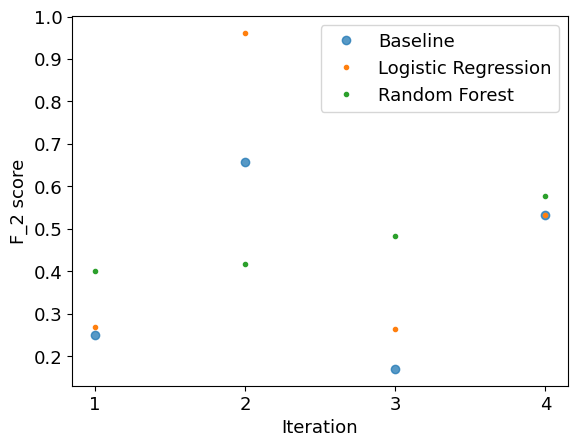

In [510]:
plt.plot(iterations, base_scores, marker = 'o', linestyle='None', label='Baseline', alpha=0.75)
plt.plot(iterations, logreg_final_test_scores, marker = '.', linestyle='None', label='Logistic Regression')
plt.plot(iterations, rf_final_test_scores, marker = '.', linestyle='None', label='Random Forest')

plt.xticks([1,2,3,4])
plt.xlabel('Iteration')
plt.ylabel('F_2 score')
plt.legend()
plt.savefig('../figures/baseline_vs_logreg_vs_rf.png')
plt.show()

In [407]:
logreg_mean = np.mean(logreg_final_test_scores)
logreg_std = np.std(logreg_final_test_scores)
logreg_mean, logreg_std

(0.50635711354835, 0.28434764294603565)

In [445]:
rf_mean = np.mean(rf_final_test_scores)
rf_std = np.std(rf_final_test_scores)
rf_mean, rf_std

(0.46936517783291976, 0.06958408685271583)

In [409]:
knn_mean = np.mean(knn_final_test_scores)
knn_std = np.std(knn_final_test_scores)
knn_mean, knn_std

(0.2624458874458874, 0.16980912645577062)

In [410]:
svc_mean = np.mean(svc_final_test_scores)
svc_std = np.std(svc_final_test_scores)
svc_mean, svc_std

(0.4602300020490908, 0.23908796155967918)

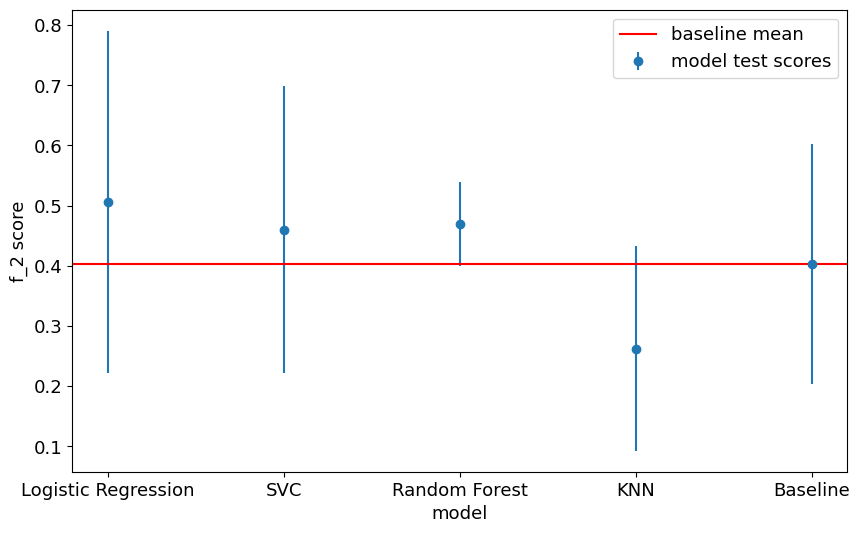

In [484]:
# visualize model performances:
x = ['Logistic Regression', 'SVC', 'Random Forest' , 'KNN', 'Baseline']
y = [logreg_mean, svc_mean, rf_mean, knn_mean, base_mean]
std = [logreg_std,svc_std,rf_std,knn_std, base_std]

plt.figure(figsize=(10,6))
plt.errorbar(x,y, yerr=std, marker = 'o', linestyle='None', label='model test scores')
plt.axhline(y=base_mean ,color = 'r', linestyle = '-', label = 'baseline mean')
plt.xlabel('model')
plt.ylabel('f_2 score')
plt.legend()
plt.savefig('../figures/test_scores.png')
plt.show()



### Model Interpretability for Logistic Regression

In [451]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

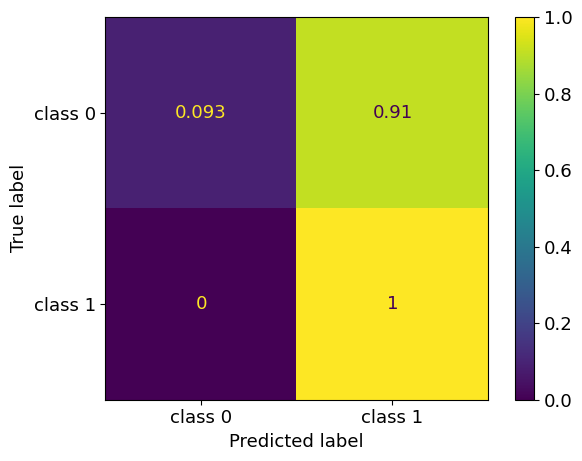

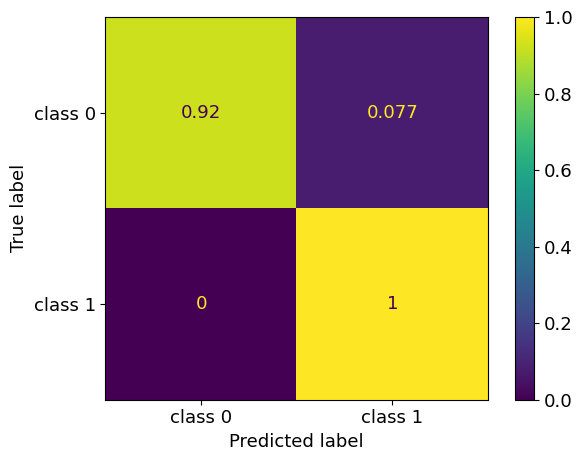

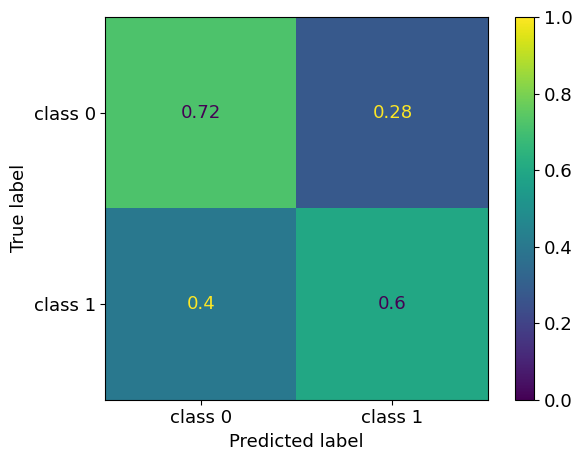

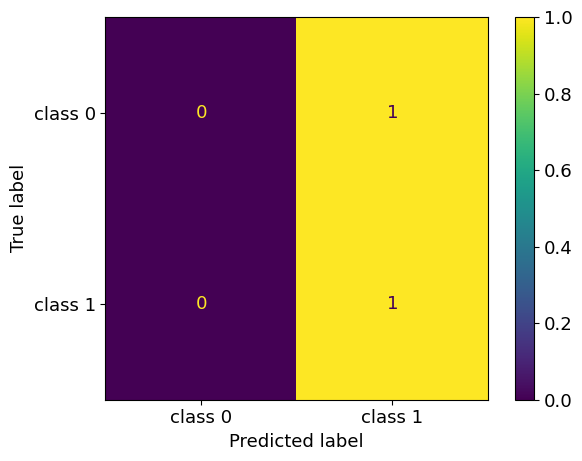

In [465]:
# confusion matrices
for i in range(4):
    best_model = logreg_final_models[i]
    X_test = logreg_X_test_sets[i]
    y_test = logreg_y_test_sets[i]
    y_pred = best_model.predict(X_test)

    # visualizing the confusion matrix:
    cm = confusion_matrix(y_test,y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
    disp.plot()
    disp.im_.set_clim(0, 1)
    plt.tight_layout()
    plt.savefig('../figures/confusion{}.png'.format(i))
    plt.show()

In [419]:
# permutation value
from sklearn.inspection import permutation_importance

# permutated importance


results = permutation_importance(best_model, X_test, y_test, n_repeats=5,random_state=42)

feature_names = X_test.columns
sorted_importance_mean_index = np.argsort(results.importances_mean)[::-1]
sorted_importance_mean_index = sorted_importance_mean_index[:10]

importance_scores = results.importances
importance_scores[sorted_importance_mean_index]

array([[0.33333333, 0.22222222, 0.16666667, 0.33333333, 0.22222222],
       [0.11111111, 0.11111111, 0.11111111, 0.        , 0.05555556],
       [0.11111111, 0.11111111, 0.        , 0.        , 0.05555556],
       [0.05555556, 0.05555556, 0.        , 0.        , 0.05555556],
       [0.        , 0.        , 0.        , 0.05555556, 0.05555556],
       [0.        , 0.05555556, 0.        , 0.        , 0.05555556],
       [0.        , 0.05555556, 0.        , 0.        , 0.05555556],
       [0.05555556, 0.05555556, 0.        , 0.        , 0.        ],
       [0.05555556, 0.05555556, 0.        , 0.        , 0.        ],
       [0.05555556, 0.05555556, 0.        , 0.        , 0.        ]])

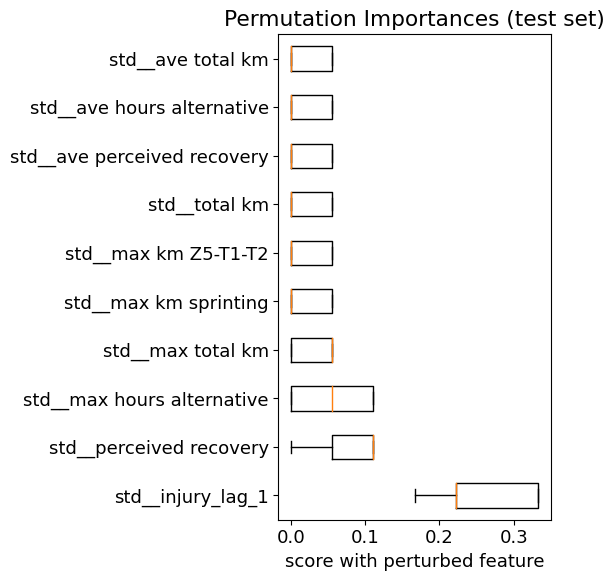

In [420]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6,6))
plt.boxplot(importance_scores[sorted_importance_mean_index].T,labels=feature_names[sorted_importance_mean_index],vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.tight_layout()
plt.savefig('../figures/permutation_importances.png',bbox_inches='tight')
plt.show()

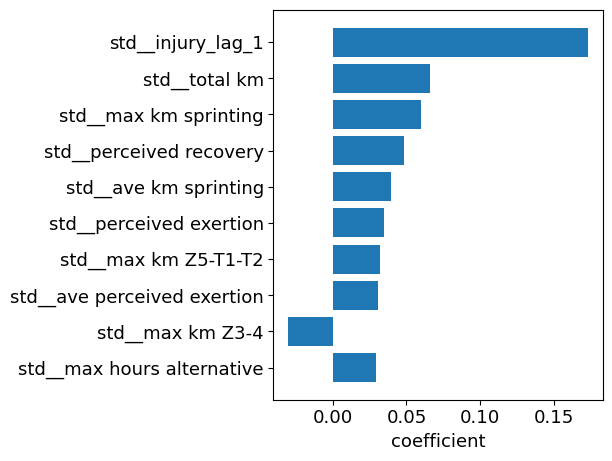

In [423]:
# size of coefficients
coefs = best_model.coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.figure(figsize=(6.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.tight_layout()
plt.savefig('../figures/LR_coefs_scaled.png',dpi=300)
plt.show()

In [427]:
# shap global importance
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.LinearExplainer(best_model, X_test)
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test)
print(np.shape(shap_values))

(18, 26)


In [430]:
shap.plots.bar(explainer(X_test), max_display=10,show=False)
plt.savefig('../figures/shap_global.png',bbox_inches = 'tight')

In [431]:
# shap local importance
# local importance shap values
# choose datapoints that are in the minority class
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)
injury_index = [idx for idx in y_test.index if y_test[idx] == 1]
injury_index

[0, 14, 15, 16, 17]

In [441]:
y_pred = best_model.predict(X_test)
y_pred

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

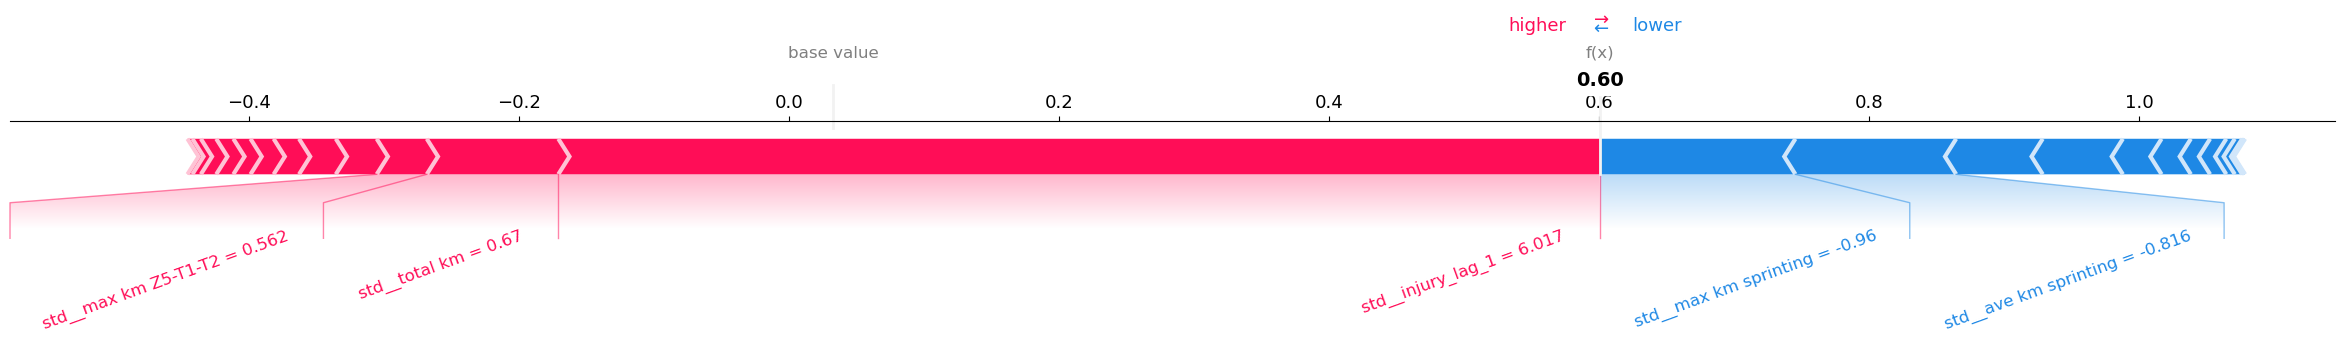

In [434]:
# correctly classified as 1
index = 0
shap.plots.force(explainer.expected_value, shap_values[index], features = np.around(X_test.iloc[index],decimals=3),feature_names = feature_names, figsize=(30,3),text_rotation=20,matplotlib=True)
#plt.savefig('../figures/force80.png',bbox_inches='tight')

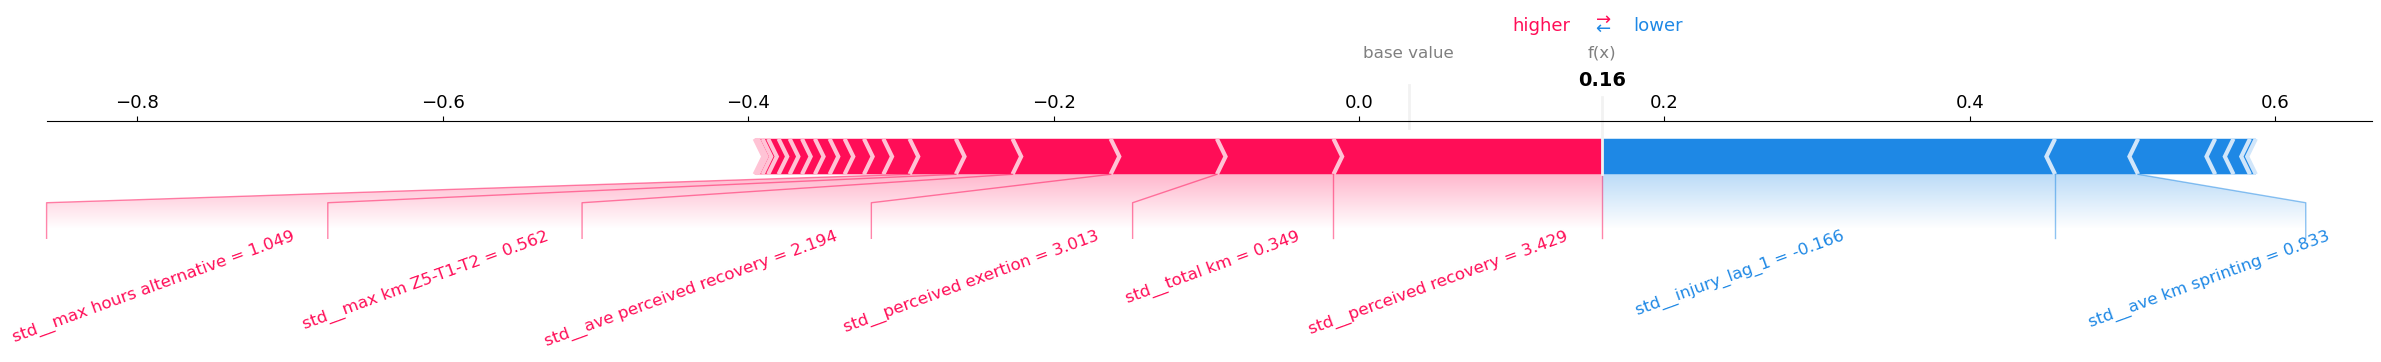

In [435]:
# correctly classified as 1
index = 14
shap.plots.force(explainer.expected_value, shap_values[index], features = np.around(X_test.iloc[index],decimals=3),feature_names = feature_names, figsize=(30,3),text_rotation=20,matplotlib=True)
#plt.savefig('../figures/force80.png',bbox_inches='tight')

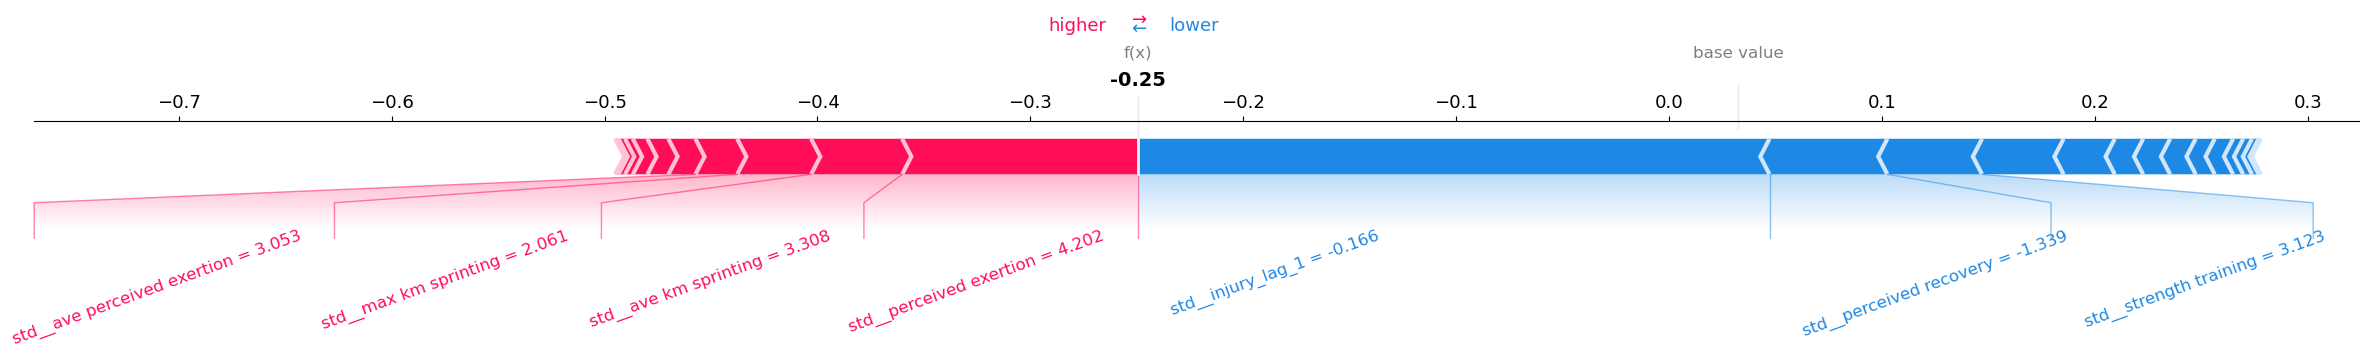

In [443]:
# correctly classified as 0
index = 8
shap.plots.force(explainer.expected_value, shap_values[index], features = np.around(X_test.iloc[index],decimals=3),feature_names = feature_names, figsize=(30,3),text_rotation=20,matplotlib=True)
#plt.savefig('../figures/force80.png',bbox_inches='tight')

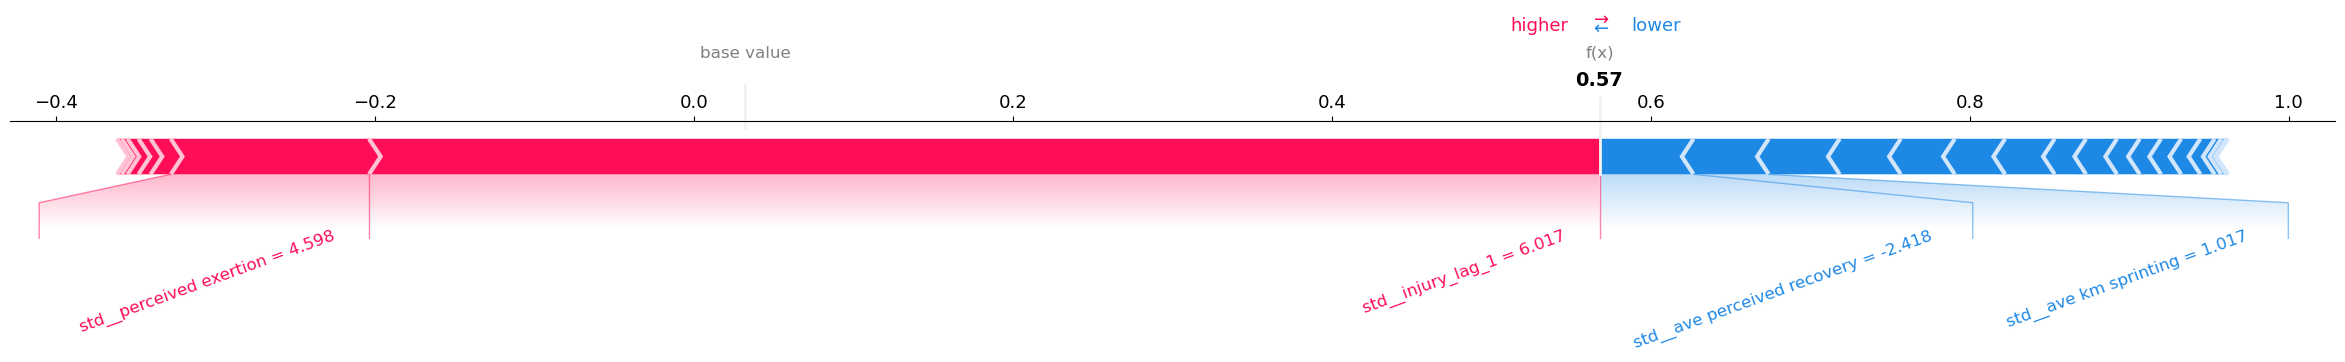

In [444]:
# missclassified as 1
index = 1
shap.plots.force(explainer.expected_value, shap_values[index], features = np.around(X_test.iloc[index],decimals=3),feature_names = feature_names, figsize=(30,3),text_rotation=20,matplotlib=True)
#plt.savefig('../figures/force80.png',bbox_inches='tight')